In [1]:
!pip install wget
import os
import torch
import pandas as pd
import numpy as np
import torch
from torch import nn


ssh_config = """
Host github.com
  IdentityFile ~/.ssh/github.pem
  User davipeag
  StrictHostKeyChecking no
"""

if os.name == 'nt':
  base_path = ""
  REPO_DIR = "."
  STORE_DIR ="." 
  print("Windows")
else:
  print("Unix-like")
  REPO_DIR = "/tmp/HeartRateRegression"
  from google.colab import drive
  drive.mount('/content/drive')
  GIT_PATH = "/content/drive/My\ Drive/deeplearning_project/github.pem"
  DATA_DIR = os.path.join(REPO_DIR, "repo")
  STORE_DIR ="/content/drive/My Drive/deeplearning_project/" 
  !mkdir ~/.ssh
  !cp -u {GIT_PATH} ~/.ssh/
  !chmod u=rw,g=,o= ~/.ssh/github.pem
  !echo "{ssh_config}" > ~/.ssh/config
  !chmod u=rw,g=,o= ~/.ssh/config
  ! (cd /tmp && git clone git@github.com:davipeag/HeartRateRegression.git)
  ! (cd {REPO_DIR} && git pull )
  import sys
  sys.path.append(REPO_DIR)

def git_pull():
  ! (cd {REPO_DIR} && git pull )

git_pull()

  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=748ed65437b72a169cc62382c894b287e872f151a7563b20426ce7c25dc66677
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget
Unix-like
Mounted at /content/drive
Cloning into 'HeartRateRegression'...
remote: Enumerating objects: 69, done.
remote: Counting objects: 100% (69/69), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 1791 (delta 36), reused 40 (delta 18), pack-reused 1722
Receiving objects: 100% (1791/1791), 128.42 MiB | 27.37 MiB/s, done.
Resolving deltas: 100% (1181/1181), done.
Already up to date.
Already up to date.


In [2]:
import random
import torch
from torch import nn
import numpy as np
args = {
    'epoch_num': 250,     # Number of epochs.
    'lr': 1.0e-3,           # Learning rate.
    'weight_decay': 10e-4, # L2 penalty.
    'momentum': 0.9,      # Momentum.
    'num_workers': 0,     # Number of workers on data loader.
    'batch_size': 128,     # Mini-batch size. 128
    'batch_test': 248,     # size of test batch
    'window': 15,
    'initial_window':5,
    'clip_norm': 6.0,     # Upper limit on gradient L2 norm ###
}
if torch.cuda.is_available():
    args['device'] = torch.device('cuda')
else:
    args['device'] = torch.device('cpu')

print(args['device'])

SEED = 1234
def reset_seeds():
  random.seed(SEED)
  np.random.seed(SEED)
  torch.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  torch.cuda.manual_seed(SEED)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False

reset_seeds()

cuda


In [3]:
from data_utils import (PpgDaliaExtractor, FormatPPGDalia)

extractor = PpgDaliaExtractor(DATA_DIR)
ppg_dalia_formatter = FormatPPGDalia()
dfs_train = [ppg_dalia_formatter.transform(extractor.extract_subject(i)) for i in range(1,16)]
[len(df)//32 for df in dfs_train]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """


[9206,
 8199,
 8735,
 9144,
 9299,
 5244,
 9337,
 8074,
 8554,
 10642,
 9042,
 7908,
 9130,
 8952,
 7933]

In [4]:
git_pull()

import importlib

import PPG
import preprocessing_utils
from PPG import FullTrainer
import RegressionHR

from RegressionHR import FullTrainer
from RegressionHR import PceLstmDefaults
from RegressionHR import PceLstmModel
from RegressionHR import TrainerJoint
from RegressionHR import  UtilitiesData


importlib.reload(PPG.AttentionDefaults)
importlib.reload(PPG)
importlib.reload(PPG.UtilitiesDataXY)
importlib.reload(PPG.Models)
importlib.reload(PPG.NoHrPceLstmModel)
importlib.reload(PPG.TrainerXY)
importlib.reload(PPG.TrainerIS)
importlib.reload(PPG.FullTrainer)
importlib.reload(PceLstmDefaults)
importlib.reload(preprocessing_utils)
importlib.reload(RegressionHR)
importlib.reload(RegressionHR.FullTrainer)
importlib.reload(RegressionHR.PceLstmDefaults)
importlib.reload(PPG.UtilitiesDataXY)
importlib.reload(preprocessing_utils)
importlib.reload(RegressionHR.TrainerJoint)
importlib.reload(RegressionHR.UtilitiesData)
importlib.reload(RegressionHR.PceLstmModel)
importlib.reload(preprocessing_utils)


Already up to date.


<module 'preprocessing_utils' from '/tmp/HeartRateRegression/preprocessing_utils.py'>

In [5]:
import matplotlib.pyplot as plt
import pickle

def compute_ensemble(results):
  
  ys = [v["predictions"][0].reshape(-1).numpy() for v in results]
  min_len_y = min([len(y) for y in ys])
  ys = [y[:min_len_y] for y in ys]
  for i in range(1, len(ys)-1):
    assert np.all(ys[i] == ys[i-1])
  ps = np.stack([v["predictions"][1].reshape(-1).numpy()[:min_len_y] for v in results])

  s = ps[0]
  for p in ps[1:]:
    s = s + p

  a = s/len(ps)
  y = ys[0]

  plt.figure()

  plt.plot(a)
  plt.plot(y)

  plt.show()

  return np.mean(np.abs(a - y)), np.mean(np.abs(ps - y))



{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 1, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 10.08478


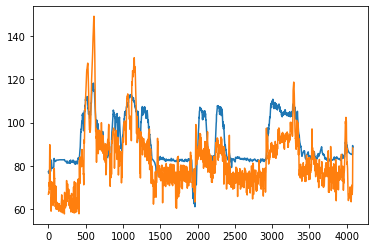

1-TS:(10.08478, 10.08478)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 2, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 9.6859665


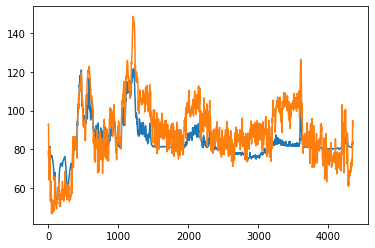

2-TS:(9.6859665, 9.6859665)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 3, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 9.412646


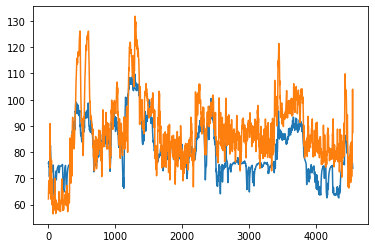

3-TS:(9.412646, 9.412646)
best val epoch: 1
[1/100]: loss_train: 11.480 loss_val 10.841 loss_ts 41.548
best val epoch: 2
[2/100]: loss_train: 10.430 loss_val 10.097 loss_ts 39.051


In [ ]:

fchoice = {
    # 'is_h_size': 64,
    'ts_per_is': 12,
    'period_s': 4,
    'step_s': 2,
    'ts_per_sample': 50,
    'ts_sub': 5,
    'batch_size': 64,
    'weight_decay': 1e-05,
    'lr': 0.005*0.9,
    #'nattrs': 40,
    'dropout_rate':0.15,
    'lstm_input': 128,
    'lstm_size': 64,
    'ts_h_size': 16,
    'sample_per_ts': 32*4
    #'disc_nlayers': 5,
    #'disc_layer_size': 64,
    #'disc_dropout_rate': 0.15
}


from PPG import UtilitiesDataXY
from collections import defaultdict
nepoch = 100
to_use_subs = [0,1,2,3,5,6,7,8]
to_use_dfs = [dfs_train[i] for i in to_use_subs]
aresults = defaultdict(dict)
for val_sub in to_use_subs:
  for ts_sub in to_use_subs:
    if val_sub == ts_sub:
      continue
    fchoice["ts_sub"] = to_use_subs.index(ts_sub)
    # fchoice["val_sub"] = to_use_subs.index(val_sub)
    filename = f"dalia_ts_no_pce_{ts_sub}_val_{val_sub}_nepoch_{nepoch}_{'-'.join([str(s) for s in to_use_subs])}_subjects.pkl"
    save_path = os.path.join(STORE_DIR, filename)
    try:
      with open(save_path , "rb") as f:
        out = pickle.load(f)
    except FileNotFoundError:
      full_trainer = RegressionHR.FullTrainer.NoPceLstmDaliaFullTrainerJointValidation(to_use_dfs, args["device"], nepoch)
      try:
        out = full_trainer.train(**fchoice)
        with open(save_path, "wb") as f:
          pickle.dump(out, f)

      except RuntimeError as e:
        raise e
        # if isinstance(e, KeyboardInterrupt):
        #   raise e
        # else:
        #   print("####")
        #   print(f"Failed: {choice}")
        #   print("###")
    
    print(out["args"], out["metric"])
    aresults[ts_sub][val_sub] = out
    print(f"{ts_sub}-TS:{compute_ensemble(list(aresults[ts_sub].values()))}")
    



{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 0, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 7.478324


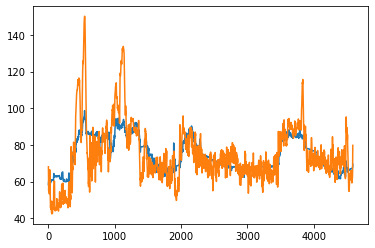

0-TS:(7.478324, 7.478324)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 1, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 7.914053


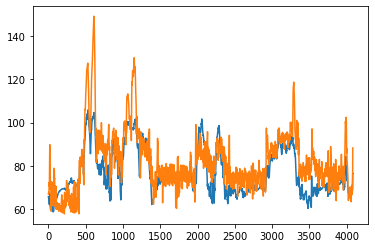

1-TS:(7.914053, 7.914053)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 2, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 9.851303


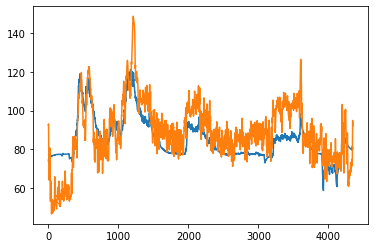

2-TS:(9.851303, 9.851303)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 3, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 9.234213


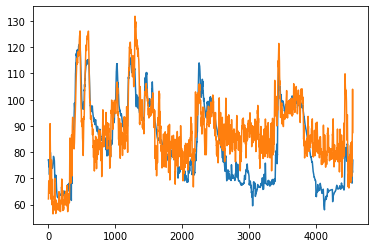

3-TS:(9.234213, 9.234213)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 5, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 28.160013


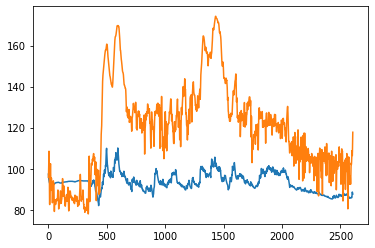

5-TS:(28.160013, 28.160013)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 6, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 9.846465


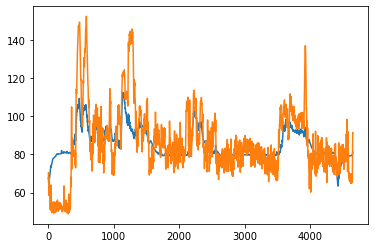

6-TS:(9.846465, 9.846465)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 7, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 14.445852


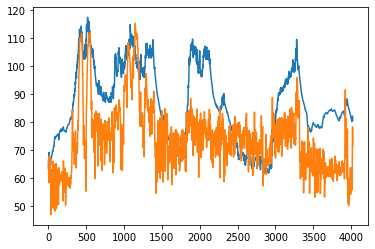

7-TS:(14.445852, 14.445852)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 8, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 10.207284


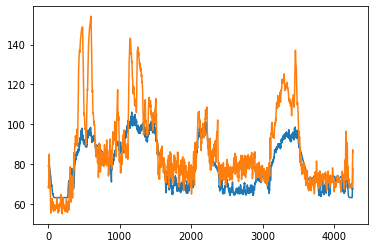

8-TS:(10.207284, 10.207284)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 9, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 9.636979


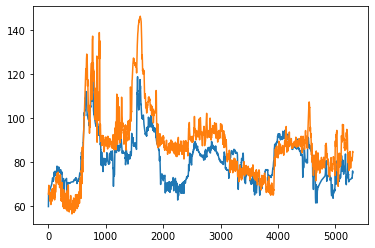

9-TS:(9.636979, 9.636979)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 10, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 21.123066


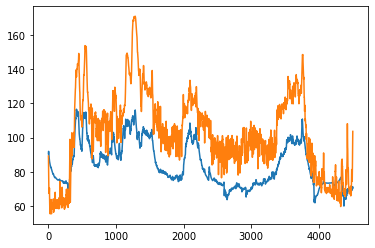

10-TS:(21.123066, 21.123066)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 11, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 18.292492


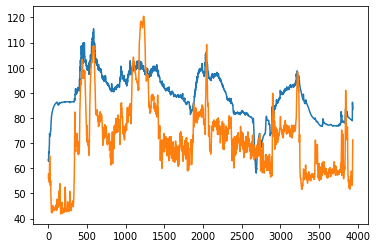

11-TS:(18.292492, 18.292492)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 12, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 10.854681


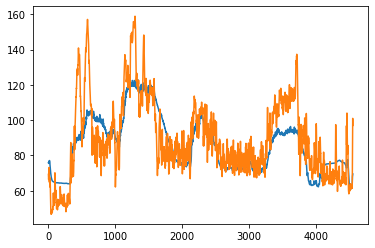

12-TS:(10.854681, 10.854681)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 13, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 16.157991


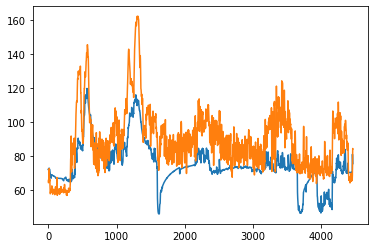

13-TS:(16.157991, 16.157991)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 14, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 10.968031


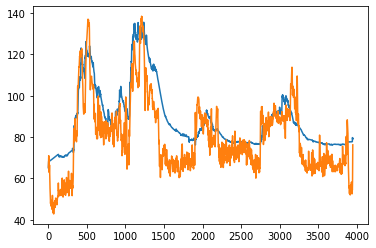

14-TS:(10.968031, 10.968031)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 0, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 8.877961


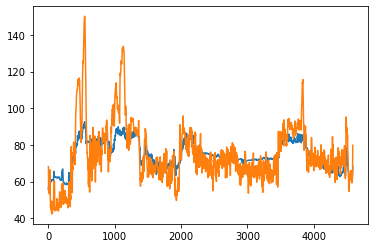

0-TS:(7.7347317, 8.178143)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 1, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 9.049694


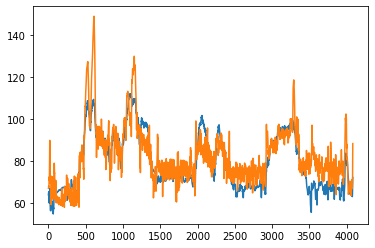

1-TS:(6.738757, 8.481873)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 2, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 9.242405


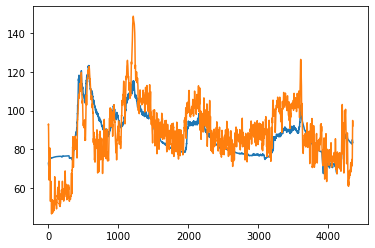

2-TS:(9.198596, 9.546854)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 3, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 27.719185


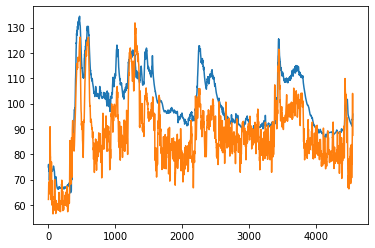

3-TS:(12.101979, 18.4767)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 4, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 43.642292


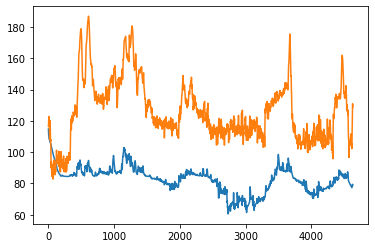

4-TS:(43.642292, 43.642292)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 6, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 21.117657


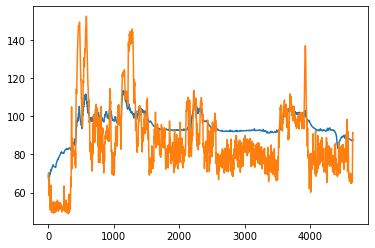

6-TS:(13.13868, 15.482061)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 7, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 9.061673


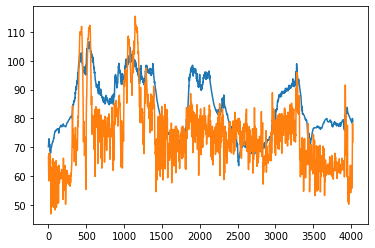

7-TS:(11.244544, 11.753762)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 8, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 13.756993


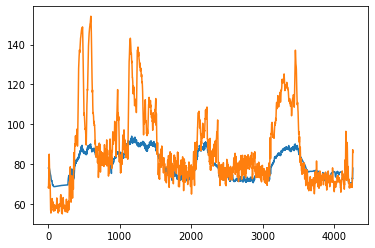

8-TS:(11.176863, 11.982139)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 9, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 7.852853


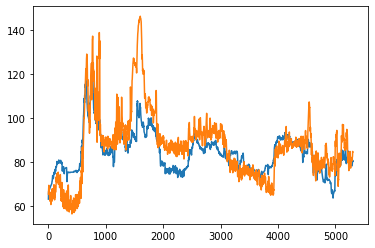

9-TS:(8.101818, 8.744916)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 10, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 21.721468


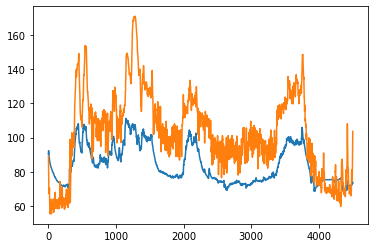

10-TS:(21.34947, 21.422266)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 11, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 14.951501


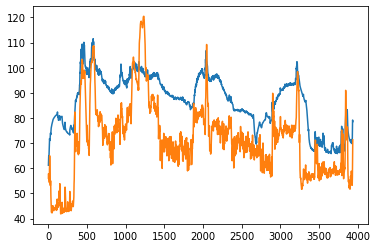

11-TS:(16.380863, 16.621996)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 12, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 12.406638


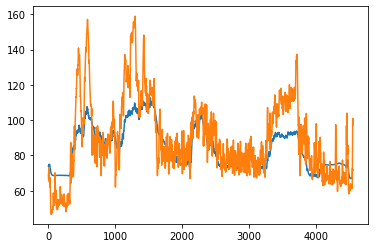

12-TS:(10.871081, 11.630659)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 13, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 12.989331


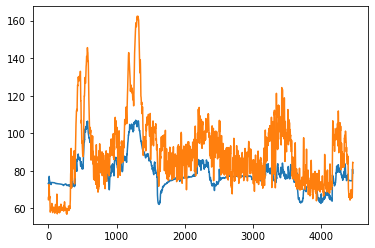

13-TS:(13.818713, 14.573661)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 14, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 9.202805


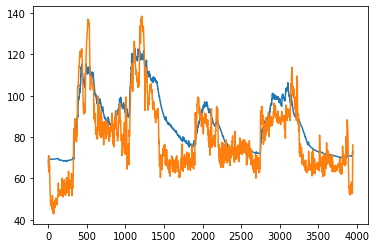

14-TS:(9.360761, 10.085418)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 0, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 11.319602


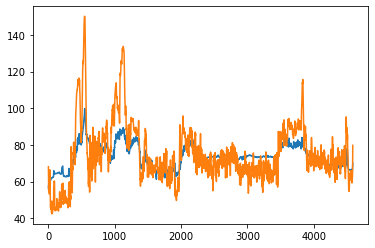

0-TS:(8.207583, 9.225296)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 1, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 8.579194


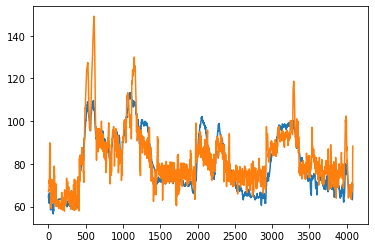

1-TS:(6.515377, 8.514314)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 2, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 10.617548


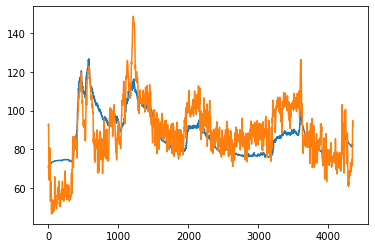

2-TS:(9.256256, 9.903752)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 4, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 49.442223


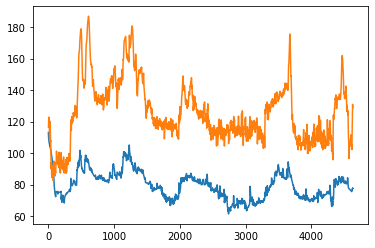

4-TS:(46.48463, 46.54226)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 5, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 33.876762


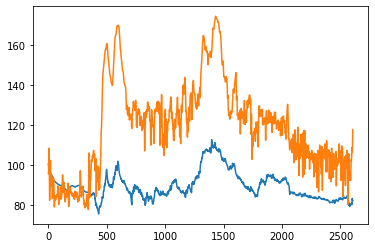

5-TS:(30.836235, 31.018389)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 6, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 26.72468


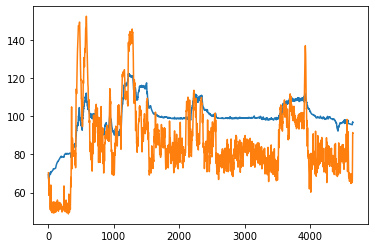

6-TS:(16.770712, 19.2296)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 7, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 17.147429


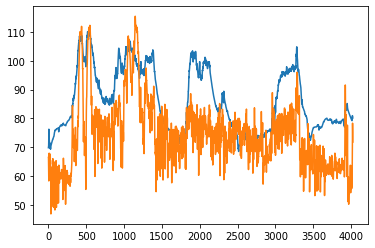

7-TS:(12.838439, 13.551651)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 8, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 12.226927


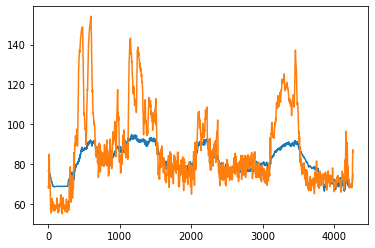

8-TS:(10.325764, 12.063734)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 9, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 8.694457


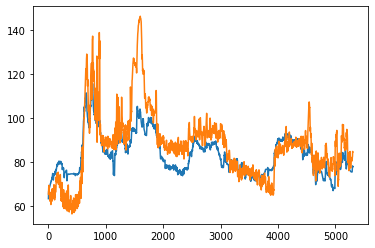

9-TS:(7.993104, 8.728097)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 10, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 21.211857


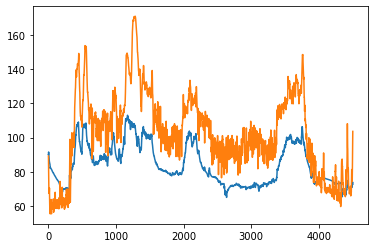

10-TS:(21.223864, 21.35213)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 11, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 14.563246


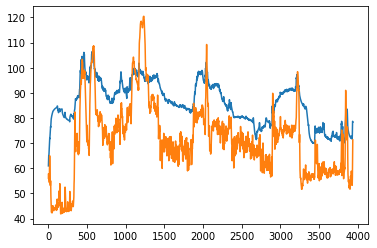

11-TS:(15.648875, 15.935745)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 12, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 11.613556


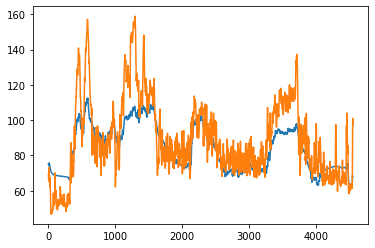

12-TS:(10.731831, 11.624958)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 13, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 12.887387


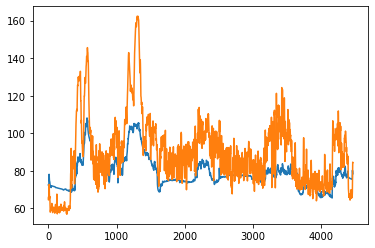

13-TS:(13.374395, 14.011569)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 14, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 9.815149


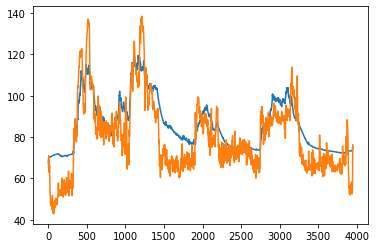

14-TS:(9.069988, 9.995328)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 0, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 9.715145


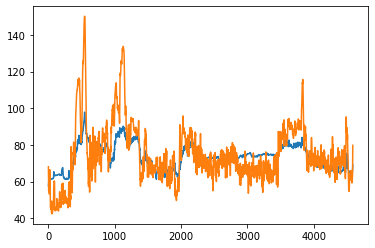

0-TS:(8.314522, 9.347758)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 1, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 7.17267


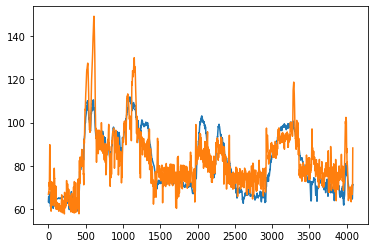

1-TS:(6.43317, 8.178904)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 3, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 7.9730015


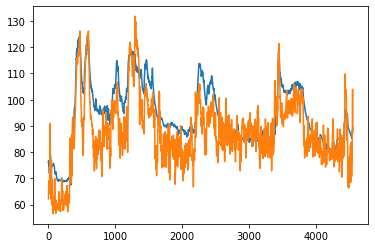

3-TS:(7.711313, 14.975468)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 4, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 39.129147


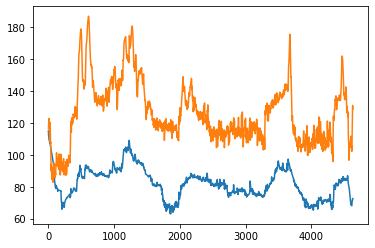

4-TS:(43.990997, 44.07122)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 5, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 34.937992


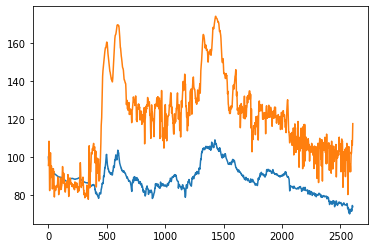

5-TS:(32.194942, 32.32492)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 6, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 15.342282


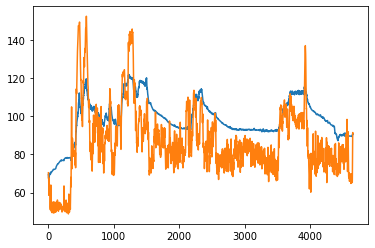

6-TS:(15.34031, 18.257772)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 7, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 13.426589


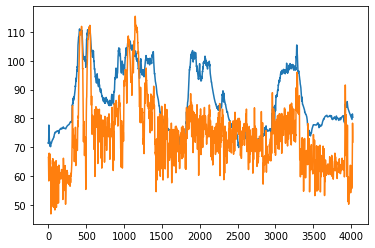

7-TS:(12.927653, 13.520386)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 8, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 10.79137


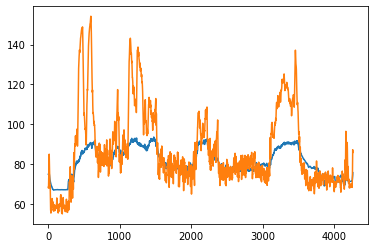

8-TS:(10.227085, 11.745644)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 9, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 7.5811653


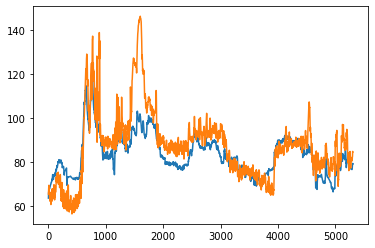

9-TS:(7.71283, 8.441363)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 10, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 23.409603


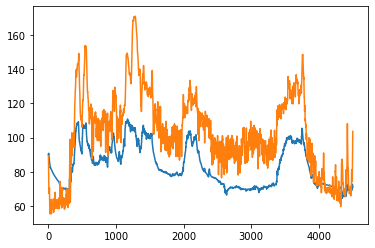

10-TS:(21.526745, 21.866497)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 11, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 15.951765


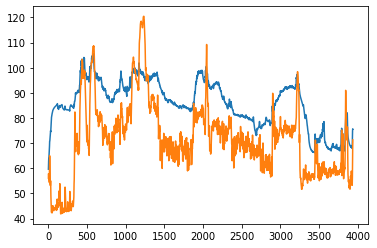

11-TS:(15.574226, 15.93975)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 12, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 11.579584


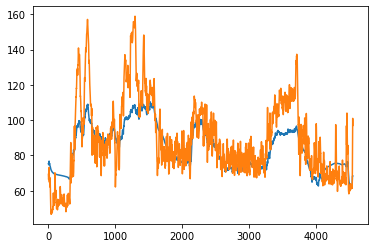

12-TS:(10.743786, 11.613614)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 13, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 11.270661


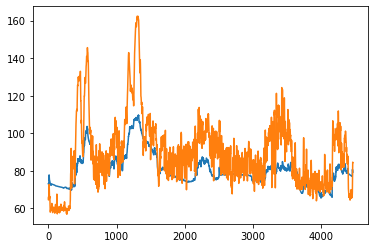

13-TS:(12.192961, 13.326343)
best val epoch: 1
[1/80]: loss_train: 15.691 loss_val 14.934 loss_ts 11.440
best val epoch: 2
[2/80]: loss_train: 13.820 loss_val 13.805 loss_ts 11.827
best val epoch: 4
[4/80]: loss_train: 12.801 loss_val 11.992 loss_ts 13.992
best val epoch: 5
[5/80]: loss_train: 11.334 loss_val 10.882 loss_ts 13.801
best val epoch: 10
[10/80]: loss_train: 10.128 loss_val 9.895 loss_ts 9.574
best val epoch: 11
[11/80]: loss_train: 7.609 loss_val 7.538 loss_ts 13.557
best val epoch: 15
[15/80]: loss_train: 7.215 loss_val 7.330 loss_ts 15.071
best val epoch: 29
[29/80]: loss_train: 6.165 loss_val 6.284 loss_ts 8.611
Final: 8.610551834106445
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 14, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 8.610552


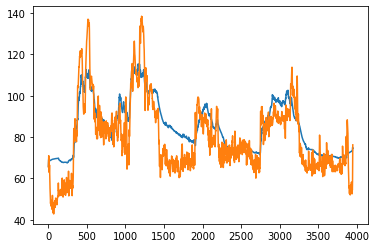

14-TS:(8.5737, 9.649134)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 0, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 9.524081


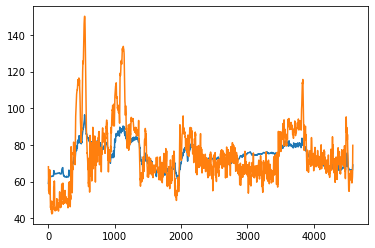

0-TS:(8.413005, 9.383023)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 2, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 8.4589615


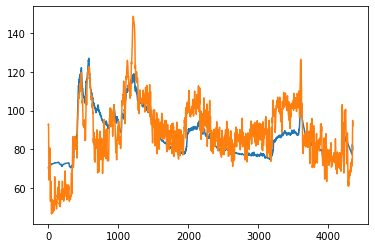

2-TS:(8.823345, 9.542555)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 3, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 24.283407


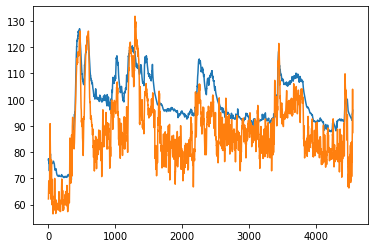

3-TS:(11.100944, 17.302452)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 4, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 48.561672


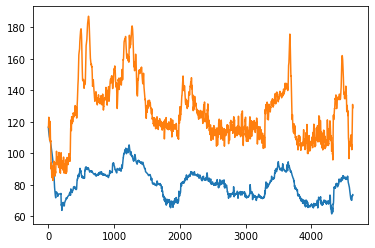

4-TS:(45.125454, 45.193836)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 5, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 35.2751


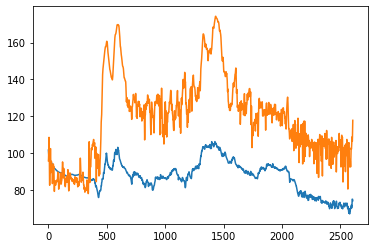

5-TS:(32.958107, 33.06247)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 6, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 10.301117


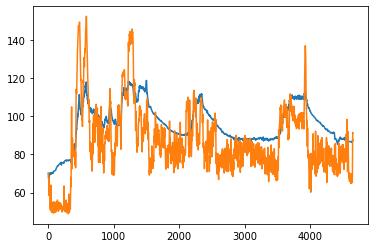

6-TS:(13.166642, 16.666441)
best val epoch: 1
[1/80]: loss_train: 15.920 loss_val 17.324 loss_ts 18.782
best val epoch: 2
[2/80]: loss_train: 14.755 loss_val 16.604 loss_ts 11.822
best val epoch: 3
[3/80]: loss_train: 13.973 loss_val 15.587 loss_ts 16.140
best val epoch: 4
[4/80]: loss_train: 13.182 loss_val 14.810 loss_ts 18.095
best val epoch: 5
[5/80]: loss_train: 11.465 loss_val 12.385 loss_ts 13.885
best val epoch: 6
[6/80]: loss_train: 10.853 loss_val 10.848 loss_ts 23.704
best val epoch: 10
[10/80]: loss_train: 9.631 loss_val 9.912 loss_ts 25.342
best val epoch: 21
[21/80]: loss_train: 7.002 loss_val 6.964 loss_ts 59.318
best val epoch: 40
[40/80]: loss_train: 6.646 loss_val 6.779 loss_ts 43.132
Final: 43.13185501098633
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 7, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000

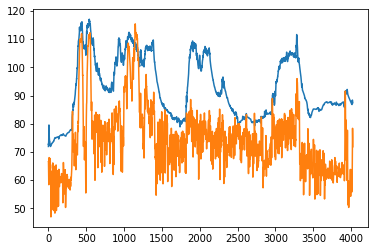

7-TS:(18.442503, 19.44268)
best val epoch: 1
[1/80]: loss_train: 16.826 loss_val 17.102 loss_ts 13.243
best val epoch: 2
[2/80]: loss_train: 15.304 loss_val 15.405 loss_ts 10.879
best val epoch: 3
[3/80]: loss_train: 14.012 loss_val 14.289 loss_ts 8.866
best val epoch: 5
[5/80]: loss_train: 12.653 loss_val 13.035 loss_ts 16.362
best val epoch: 10
[10/80]: loss_train: 12.332 loss_val 12.823 loss_ts 17.226
best val epoch: 11
[11/80]: loss_train: 12.085 loss_val 12.092 loss_ts 15.015
best val epoch: 12
[12/80]: loss_train: 9.922 loss_val 9.904 loss_ts 16.086
best val epoch: 19
[19/80]: loss_train: 9.433 loss_val 9.718 loss_ts 16.920
best val epoch: 32
[32/80]: loss_train: 8.867 loss_val 9.586 loss_ts 17.921
best val epoch: 36
[36/80]: loss_train: 8.594 loss_val 9.331 loss_ts 14.491
best val epoch: 37
[37/80]: loss_train: 8.058 loss_val 8.545 loss_ts 15.563
best val epoch: 38
[38/80]: loss_train: 7.759 loss_val 8.197 loss_ts 15.395
best val epoch: 41
[41/80]: loss_train: 7.837 loss_val 8.0

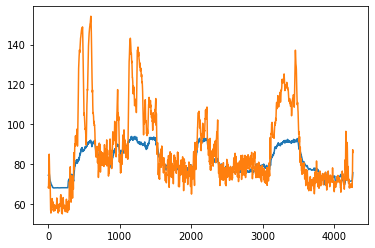

8-TS:(9.887885, 11.240228)
best val epoch: 1
[1/80]: loss_train: 15.176 loss_val 15.860 loss_ts 10.270
best val epoch: 2
[2/80]: loss_train: 14.384 loss_val 15.256 loss_ts 10.583
best val epoch: 3
[3/80]: loss_train: 12.423 loss_val 13.173 loss_ts 9.183
best val epoch: 6
[6/80]: loss_train: 11.366 loss_val 12.374 loss_ts 23.184
best val epoch: 7
[7/80]: loss_train: 11.397 loss_val 12.323 loss_ts 13.644
best val epoch: 8
[8/80]: loss_train: 11.054 loss_val 11.824 loss_ts 13.958
best val epoch: 9
[9/80]: loss_train: 10.648 loss_val 11.393 loss_ts 13.088
best val epoch: 10
[10/80]: loss_train: 10.698 loss_val 11.307 loss_ts 13.220
best val epoch: 12
[12/80]: loss_train: 8.026 loss_val 8.421 loss_ts 11.401
best val epoch: 19
[19/80]: loss_train: 6.756 loss_val 7.300 loss_ts 11.338
best val epoch: 37
[37/80]: loss_train: 6.362 loss_val 7.007 loss_ts 8.159
best val epoch: 48
[48/80]: loss_train: 6.240 loss_val 6.745 loss_ts 12.664
Final: 12.663869857788086
{'net_args': {'dropout_rate': 0.15,

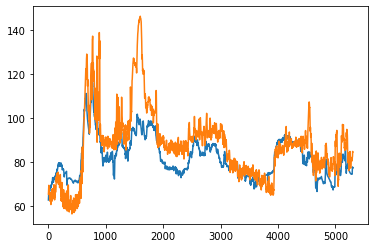

9-TS:(8.478682, 9.285865)
best val epoch: 1
[1/80]: loss_train: 16.851 loss_val 18.063 loss_ts 27.268
best val epoch: 2
[2/80]: loss_train: 14.416 loss_val 16.059 loss_ts 22.235
best val epoch: 3
[3/80]: loss_train: 14.369 loss_val 16.004 loss_ts 25.885
best val epoch: 4
[4/80]: loss_train: 11.046 loss_val 11.687 loss_ts 26.532
best val epoch: 6
[6/80]: loss_train: 9.887 loss_val 10.521 loss_ts 26.656
best val epoch: 7
[7/80]: loss_train: 9.058 loss_val 9.510 loss_ts 24.868
best val epoch: 11
[11/80]: loss_train: 8.631 loss_val 9.099 loss_ts 25.601
best val epoch: 16
[16/80]: loss_train: 7.487 loss_val 7.817 loss_ts 17.851
best val epoch: 27
[27/80]: loss_train: 7.210 loss_val 7.717 loss_ts 16.631
best val epoch: 29
[29/80]: loss_train: 7.134 loss_val 7.393 loss_ts 22.179
best val epoch: 37
[37/80]: loss_train: 6.593 loss_val 6.797 loss_ts 22.419
best val epoch: 41
[41/80]: loss_train: 5.988 loss_val 6.508 loss_ts 20.971
Final: 20.971343994140625
{'net_args': {'dropout_rate': 0.15, 'ls

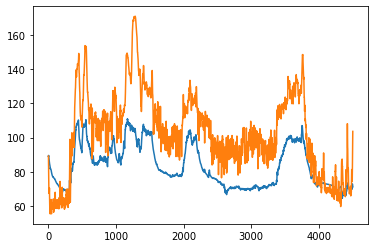

10-TS:(21.398417, 21.687468)
best val epoch: 1
[1/80]: loss_train: 14.409 loss_val 14.580 loss_ts 21.258
best val epoch: 2
[2/80]: loss_train: 13.367 loss_val 13.817 loss_ts 17.852
best val epoch: 3
[3/80]: loss_train: 9.558 loss_val 9.783 loss_ts 42.644
best val epoch: 7
[7/80]: loss_train: 9.367 loss_val 9.519 loss_ts 12.252
best val epoch: 12
[12/80]: loss_train: 7.874 loss_val 8.800 loss_ts 37.247
best val epoch: 21
[21/80]: loss_train: 7.683 loss_val 8.642 loss_ts 39.457
best val epoch: 26
[26/80]: loss_train: 6.875 loss_val 7.972 loss_ts 21.177
best val epoch: 34
[34/80]: loss_train: 6.560 loss_val 7.869 loss_ts 19.907
best val epoch: 36
[36/80]: loss_train: 6.272 loss_val 7.472 loss_ts 15.710
best val epoch: 47
[47/80]: loss_train: 6.225 loss_val 7.432 loss_ts 19.730
best val epoch: 63
[63/80]: loss_train: 5.974 loss_val 7.314 loss_ts 18.648
best val epoch: 79
[79/80]: loss_train: 5.890 loss_val 7.237 loss_ts 14.915
Final: 14.915498733520508
{'net_args': {'dropout_rate': 0.15, '

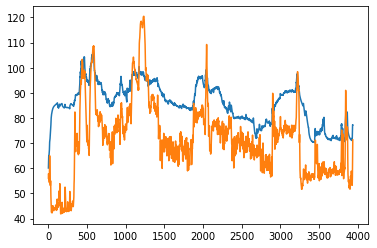

11-TS:(15.410675, 15.734901)
best val epoch: 1
[1/80]: loss_train: 15.397 loss_val 15.702 loss_ts 14.482
best val epoch: 2
[2/80]: loss_train: 14.872 loss_val 15.221 loss_ts 12.487
best val epoch: 3
[3/80]: loss_train: 13.661 loss_val 14.479 loss_ts 13.158
best val epoch: 4
[4/80]: loss_train: 12.325 loss_val 13.279 loss_ts 17.309
best val epoch: 5
[5/80]: loss_train: 10.465 loss_val 10.652 loss_ts 18.626
best val epoch: 8
[8/80]: loss_train: 8.641 loss_val 9.425 loss_ts 20.417
best val epoch: 11
[11/80]: loss_train: 8.855 loss_val 9.359 loss_ts 16.819
best val epoch: 13
[13/80]: loss_train: 7.318 loss_val 7.896 loss_ts 39.052
best val epoch: 14
[14/80]: loss_train: 6.393 loss_val 6.780 loss_ts 13.505
best val epoch: 22
[22/80]: loss_train: 6.031 loss_val 6.594 loss_ts 22.987
best val epoch: 65
[65/80]: loss_train: 5.404 loss_val 6.498 loss_ts 16.845
Final: 16.84455108642578
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, '

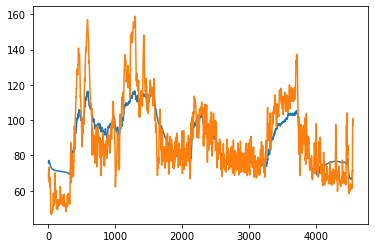

12-TS:(9.484543, 12.659801)
best val epoch: 1
[1/80]: loss_train: 16.846 loss_val 16.570 loss_ts 14.533
best val epoch: 2
[2/80]: loss_train: 13.576 loss_val 13.723 loss_ts 10.991
best val epoch: 3
[3/80]: loss_train: 10.982 loss_val 11.711 loss_ts 20.891
best val epoch: 4
[4/80]: loss_train: 9.874 loss_val 10.355 loss_ts 16.049
best val epoch: 7
[7/80]: loss_train: 9.243 loss_val 9.246 loss_ts 15.535
best val epoch: 9
[9/80]: loss_train: 8.072 loss_val 7.681 loss_ts 15.044
best val epoch: 14
[14/80]: loss_train: 7.198 loss_val 7.023 loss_ts 12.095
best val epoch: 21
[21/80]: loss_train: 6.034 loss_val 6.326 loss_ts 12.179
best val epoch: 53
[53/80]: loss_train: 5.382 loss_val 5.914 loss_ts 10.448
Final: 10.448426246643066
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 13, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000

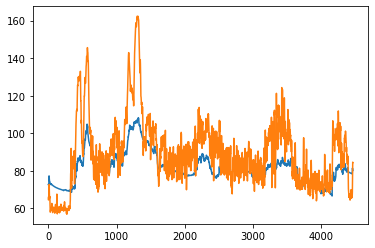

13-TS:(11.308781, 12.750759)
best val epoch: 1
[1/80]: loss_train: 16.059 loss_val 15.832 loss_ts 11.199
best val epoch: 2
[2/80]: loss_train: 13.702 loss_val 14.147 loss_ts 13.841
best val epoch: 3
[3/80]: loss_train: 11.517 loss_val 11.724 loss_ts 11.851
best val epoch: 4
[4/80]: loss_train: 11.056 loss_val 11.318 loss_ts 12.856
best val epoch: 7
[7/80]: loss_train: 10.335 loss_val 10.357 loss_ts 8.558
best val epoch: 9
[9/80]: loss_train: 9.915 loss_val 9.587 loss_ts 10.921
best val epoch: 10
[10/80]: loss_train: 9.295 loss_val 8.910 loss_ts 9.780
best val epoch: 11
[11/80]: loss_train: 8.906 loss_val 8.811 loss_ts 10.591
best val epoch: 13
[13/80]: loss_train: 7.949 loss_val 7.811 loss_ts 9.291
best val epoch: 20
[20/80]: loss_train: 6.884 loss_val 7.071 loss_ts 10.582
best val epoch: 24
[24/80]: loss_train: 6.262 loss_val 6.525 loss_ts 13.630
best val epoch: 59
[59/80]: loss_train: 5.439 loss_val 6.458 loss_ts 10.335
Final: 10.334977149963379
{'net_args': {'dropout_rate': 0.15, 'l

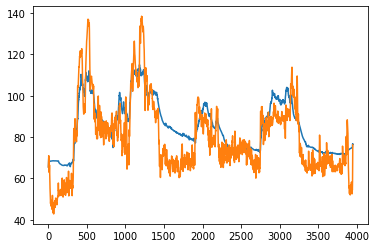

14-TS:(8.810764, 9.7863035)
best val epoch: 1
[1/80]: loss_train: 16.777 loss_val 15.437 loss_ts 6.870
best val epoch: 2
[2/80]: loss_train: 13.040 loss_val 12.234 loss_ts 7.988
best val epoch: 3
[3/80]: loss_train: 12.087 loss_val 11.353 loss_ts 11.269
best val epoch: 4
[4/80]: loss_train: 10.451 loss_val 9.614 loss_ts 7.211
best val epoch: 5
[5/80]: loss_train: 9.729 loss_val 9.165 loss_ts 9.656
best val epoch: 7
[7/80]: loss_train: 7.775 loss_val 7.354 loss_ts 7.217
best val epoch: 9
[9/80]: loss_train: 7.692 loss_val 7.242 loss_ts 5.955
best val epoch: 11
[11/80]: loss_train: 7.321 loss_val 7.057 loss_ts 6.331
best val epoch: 17
[17/80]: loss_train: 7.381 loss_val 6.997 loss_ts 6.236
best val epoch: 31
[31/80]: loss_train: 7.034 loss_val 6.651 loss_ts 9.494
best val epoch: 35
[35/80]: loss_train: 6.579 loss_val 6.205 loss_ts 8.231
best val epoch: 58
[58/80]: loss_train: 5.820 loss_val 5.951 loss_ts 5.621
best val epoch: 70
[70/80]: loss_train: 5.386 loss_val 5.730 loss_ts 7.262
Fin

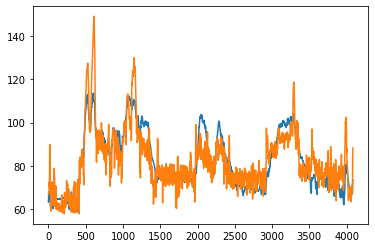

1-TS:(5.8591633, 7.995533)
best val epoch: 1
[1/80]: loss_train: 18.058 loss_val 18.585 loss_ts 14.470
best val epoch: 2
[2/80]: loss_train: 15.883 loss_val 16.964 loss_ts 10.486
best val epoch: 3
[3/80]: loss_train: 14.515 loss_val 15.492 loss_ts 10.028
best val epoch: 4
[4/80]: loss_train: 13.956 loss_val 15.470 loss_ts 13.397
best val epoch: 5
[5/80]: loss_train: 11.780 loss_val 11.810 loss_ts 16.465
best val epoch: 7
[7/80]: loss_train: 12.058 loss_val 11.586 loss_ts 16.955
best val epoch: 10
[10/80]: loss_train: 10.616 loss_val 10.350 loss_ts 10.418
best val epoch: 11
[11/80]: loss_train: 9.089 loss_val 8.630 loss_ts 11.255
best val epoch: 23
[23/80]: loss_train: 7.957 loss_val 8.015 loss_ts 12.933
best val epoch: 29
[29/80]: loss_train: 6.963 loss_val 6.899 loss_ts 12.112
Final: 12.111515045166016
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample'

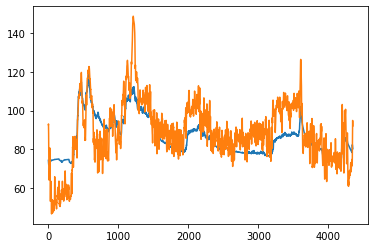

2-TS:(8.971654, 10.056347)
best val epoch: 1
[1/80]: loss_train: 16.282 loss_val 17.199 loss_ts 8.166
best val epoch: 2
[2/80]: loss_train: 14.973 loss_val 15.375 loss_ts 8.493
best val epoch: 3
[3/80]: loss_train: 14.399 loss_val 14.778 loss_ts 9.705
best val epoch: 4
[4/80]: loss_train: 11.703 loss_val 11.855 loss_ts 14.950
best val epoch: 8
[8/80]: loss_train: 11.625 loss_val 11.706 loss_ts 13.694
best val epoch: 9
[9/80]: loss_train: 10.771 loss_val 11.071 loss_ts 12.285
best val epoch: 11
[11/80]: loss_train: 10.073 loss_val 10.231 loss_ts 12.674
best val epoch: 14
[14/80]: loss_train: 10.102 loss_val 10.132 loss_ts 12.477
best val epoch: 15
[15/80]: loss_train: 9.944 loss_val 10.091 loss_ts 9.424
best val epoch: 19
[19/80]: loss_train: 9.931 loss_val 9.869 loss_ts 11.605
best val epoch: 21
[21/80]: loss_train: 9.517 loss_val 9.591 loss_ts 11.550
best val epoch: 26
[26/80]: loss_train: 8.668 loss_val 8.573 loss_ts 10.994
best val epoch: 28
[28/80]: loss_train: 8.282 loss_val 8.247

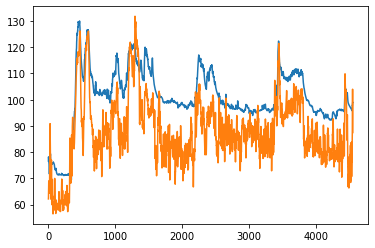

3-TS:(13.463151, 18.535)
best val epoch: 1
[1/80]: loss_train: 13.079 loss_val 12.575 loss_ts 42.066
best val epoch: 2
[2/80]: loss_train: 12.391 loss_val 12.300 loss_ts 48.037
best val epoch: 3
[3/80]: loss_train: 11.567 loss_val 11.379 loss_ts 45.270
best val epoch: 4
[4/80]: loss_train: 10.602 loss_val 10.403 loss_ts 49.664
best val epoch: 7
[7/80]: loss_train: 8.136 loss_val 8.445 loss_ts 40.306
best val epoch: 11
[11/80]: loss_train: 7.171 loss_val 7.623 loss_ts 40.790
best val epoch: 18
[18/80]: loss_train: 6.106 loss_val 6.575 loss_ts 47.850
best val epoch: 19
[19/80]: loss_train: 5.938 loss_val 6.535 loss_ts 46.770
best val epoch: 28
[28/80]: loss_train: 5.876 loss_val 6.445 loss_ts 47.856
best val epoch: 43
[43/80]: loss_train: 5.786 loss_val 6.400 loss_ts 44.108
best val epoch: 47
[47/80]: loss_train: 5.606 loss_val 6.194 loss_ts 47.352
best val epoch: 66
[66/80]: loss_train: 5.603 loss_val 6.177 loss_ts 46.924
best val epoch: 67
[67/80]: loss_train: 5.182 loss_val 5.852 loss

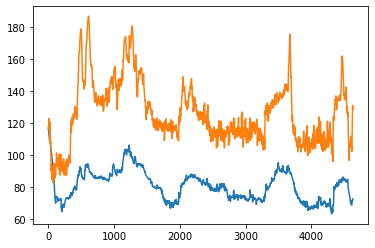

4-TS:(45.32389, 45.384342)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 5, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 19.753042


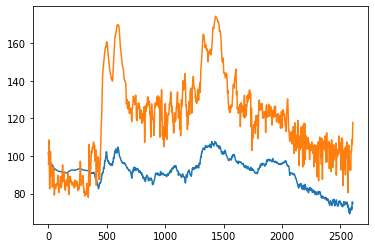

5-TS:(29.992891, 30.400585)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 6, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 11.5078745


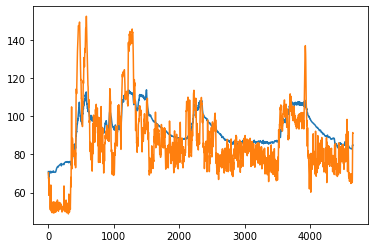

6-TS:(11.491867, 15.806681)
best val epoch: 1
[1/80]: loss_train: 17.580 loss_val 16.105 loss_ts 12.232
best val epoch: 2
[2/80]: loss_train: 15.286 loss_val 14.463 loss_ts 12.626
best val epoch: 3
[3/80]: loss_train: 14.404 loss_val 13.691 loss_ts 12.650
best val epoch: 4
[4/80]: loss_train: 14.850 loss_val 13.437 loss_ts 8.517
best val epoch: 5
[5/80]: loss_train: 12.010 loss_val 10.797 loss_ts 8.881
best val epoch: 7
[7/80]: loss_train: 9.294 loss_val 8.603 loss_ts 38.698
best val epoch: 9
[9/80]: loss_train: 7.877 loss_val 6.966 loss_ts 17.675
best val epoch: 16
[16/80]: loss_train: 7.798 loss_val 6.846 loss_ts 36.246
best val epoch: 22
[22/80]: loss_train: 7.353 loss_val 6.659 loss_ts 21.139
best val epoch: 25
[25/80]: loss_train: 6.292 loss_val 5.851 loss_ts 29.014
Final: 29.014257431030273
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, '

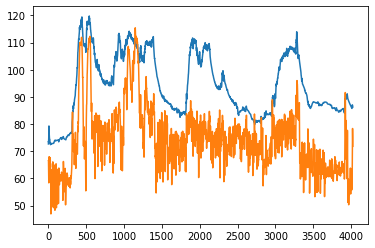

7-TS:(20.173477, 21.037943)
best val epoch: 1
[1/80]: loss_train: 15.659 loss_val 16.150 loss_ts 11.743
best val epoch: 2
[2/80]: loss_train: 14.970 loss_val 15.462 loss_ts 10.493
best val epoch: 3
[3/80]: loss_train: 13.737 loss_val 14.287 loss_ts 8.998
best val epoch: 4
[4/80]: loss_train: 13.218 loss_val 13.863 loss_ts 9.866
best val epoch: 5
[5/80]: loss_train: 12.352 loss_val 12.786 loss_ts 9.189
best val epoch: 6
[6/80]: loss_train: 12.081 loss_val 12.571 loss_ts 13.945
best val epoch: 9
[9/80]: loss_train: 11.432 loss_val 11.731 loss_ts 13.956
best val epoch: 11
[11/80]: loss_train: 10.973 loss_val 11.231 loss_ts 15.155
best val epoch: 12
[12/80]: loss_train: 10.507 loss_val 10.920 loss_ts 13.654
best val epoch: 13
[13/80]: loss_train: 8.766 loss_val 9.097 loss_ts 12.554
best val epoch: 15
[15/80]: loss_train: 7.948 loss_val 8.515 loss_ts 12.358
best val epoch: 23
[23/80]: loss_train: 7.794 loss_val 8.409 loss_ts 11.946
best val epoch: 26
[26/80]: loss_train: 6.795 loss_val 7.67

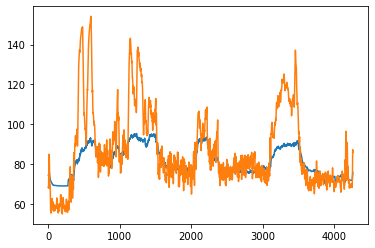

8-TS:(9.901814, 11.111452)
best val epoch: 1
[1/80]: loss_train: 15.387 loss_val 15.842 loss_ts 10.478
best val epoch: 2
[2/80]: loss_train: 14.285 loss_val 14.923 loss_ts 10.653
best val epoch: 3
[3/80]: loss_train: 12.239 loss_val 12.830 loss_ts 9.032
best val epoch: 4
[4/80]: loss_train: 9.648 loss_val 10.403 loss_ts 14.834
best val epoch: 5
[5/80]: loss_train: 8.750 loss_val 9.398 loss_ts 11.609
best val epoch: 8
[8/80]: loss_train: 8.146 loss_val 8.491 loss_ts 13.910
best val epoch: 16
[16/80]: loss_train: 8.191 loss_val 8.370 loss_ts 21.036
best val epoch: 19
[19/80]: loss_train: 7.548 loss_val 7.974 loss_ts 16.090
best val epoch: 40
[40/80]: loss_train: 6.952 loss_val 7.525 loss_ts 8.078
best val epoch: 73
[73/80]: loss_train: 6.739 loss_val 7.389 loss_ts 9.058
best val epoch: 74
[74/80]: loss_train: 6.057 loss_val 7.023 loss_ts 11.642
Final: 11.641636848449707
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs'

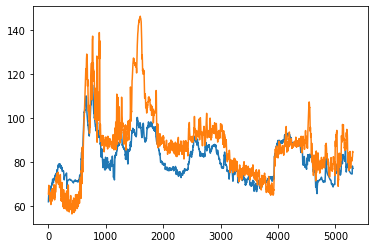

9-TS:(8.8022585, 9.678493)
best val epoch: 1
[1/80]: loss_train: 15.218 loss_val 13.478 loss_ts 20.046
best val epoch: 2
[2/80]: loss_train: 14.376 loss_val 12.378 loss_ts 23.484
best val epoch: 3
[3/80]: loss_train: 10.516 loss_val 9.114 loss_ts 16.356
best val epoch: 13
[13/80]: loss_train: 7.390 loss_val 7.617 loss_ts 24.809
best val epoch: 20
[20/80]: loss_train: 7.556 loss_val 7.443 loss_ts 19.654
best val epoch: 41
[41/80]: loss_train: 7.200 loss_val 7.212 loss_ts 28.002
best val epoch: 46
[46/80]: loss_train: 6.660 loss_val 6.904 loss_ts 15.046
best val epoch: 48
[48/80]: loss_train: 6.343 loss_val 6.589 loss_ts 20.403
best val epoch: 65
[65/80]: loss_train: 5.838 loss_val 6.533 loss_ts 22.651
best val epoch: 70
[70/80]: loss_train: 5.796 loss_val 6.347 loss_ts 22.640
Final: 22.639606475830078
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 5

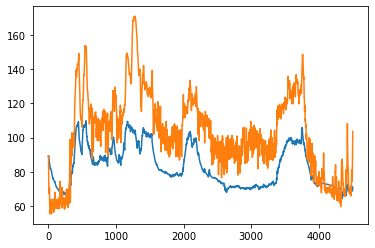

10-TS:(21.526623, 21.846159)
best val epoch: 1
[1/80]: loss_train: 15.009 loss_val 15.044 loss_ts 20.114
best val epoch: 2
[2/80]: loss_train: 13.167 loss_val 13.009 loss_ts 20.052
best val epoch: 3
[3/80]: loss_train: 11.494 loss_val 11.438 loss_ts 11.712
best val epoch: 5
[5/80]: loss_train: 11.138 loss_val 11.258 loss_ts 12.868
best val epoch: 7
[7/80]: loss_train: 10.332 loss_val 10.296 loss_ts 13.667
best val epoch: 8
[8/80]: loss_train: 9.025 loss_val 9.082 loss_ts 17.366
best val epoch: 9
[9/80]: loss_train: 8.701 loss_val 8.796 loss_ts 16.219
best val epoch: 11
[11/80]: loss_train: 7.869 loss_val 8.066 loss_ts 46.607
best val epoch: 16
[16/80]: loss_train: 7.040 loss_val 7.374 loss_ts 36.120
best val epoch: 35
[35/80]: loss_train: 6.268 loss_val 6.697 loss_ts 18.389
best val epoch: 55
[55/80]: loss_train: 5.805 loss_val 6.484 loss_ts 16.499
best val epoch: 62
[62/80]: loss_train: 5.553 loss_val 6.453 loss_ts 19.227
Final: 19.227317810058594
{'net_args': {'dropout_rate': 0.15, '

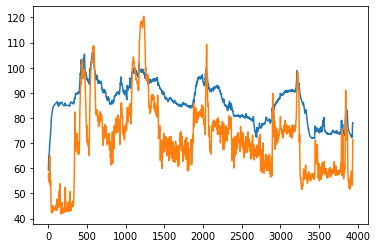

11-TS:(16.022676, 16.316969)
best val epoch: 1
[1/80]: loss_train: 16.450 loss_val 15.377 loss_ts 15.703
best val epoch: 2
[2/80]: loss_train: 14.497 loss_val 13.715 loss_ts 12.824
best val epoch: 3
[3/80]: loss_train: 13.635 loss_val 13.062 loss_ts 15.702
best val epoch: 4
[4/80]: loss_train: 13.279 loss_val 12.680 loss_ts 17.610
best val epoch: 5
[5/80]: loss_train: 10.275 loss_val 10.023 loss_ts 16.072
best val epoch: 6
[6/80]: loss_train: 9.647 loss_val 9.725 loss_ts 14.854
best val epoch: 7
[7/80]: loss_train: 8.640 loss_val 8.310 loss_ts 12.392
best val epoch: 8
[8/80]: loss_train: 8.011 loss_val 7.824 loss_ts 12.069
best val epoch: 11
[11/80]: loss_train: 7.621 loss_val 7.509 loss_ts 12.087
best val epoch: 12
[12/80]: loss_train: 6.550 loss_val 6.951 loss_ts 27.001
best val epoch: 23
[23/80]: loss_train: 6.335 loss_val 6.313 loss_ts 12.447
best val epoch: 25
[25/80]: loss_train: 5.947 loss_val 6.022 loss_ts 12.071
best val epoch: 62
[62/80]: loss_train: 5.346 loss_val 5.695 loss

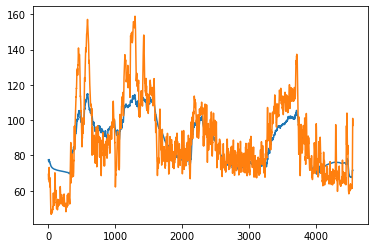

12-TS:(9.659644, 12.5545435)
best val epoch: 1
[1/80]: loss_train: 15.971 loss_val 17.007 loss_ts 12.581
best val epoch: 2
[2/80]: loss_train: 14.373 loss_val 15.144 loss_ts 10.768
best val epoch: 5
[5/80]: loss_train: 10.954 loss_val 11.113 loss_ts 15.302
best val epoch: 6
[6/80]: loss_train: 8.675 loss_val 8.981 loss_ts 13.415
best val epoch: 7
[7/80]: loss_train: 8.173 loss_val 8.517 loss_ts 15.787
best val epoch: 12
[12/80]: loss_train: 7.733 loss_val 8.169 loss_ts 16.173
best val epoch: 14
[14/80]: loss_train: 7.505 loss_val 7.723 loss_ts 14.336
best val epoch: 20
[20/80]: loss_train: 6.782 loss_val 7.216 loss_ts 13.140
best val epoch: 25
[25/80]: loss_train: 6.808 loss_val 6.993 loss_ts 9.866
best val epoch: 33
[33/80]: loss_train: 6.554 loss_val 6.857 loss_ts 10.472
best val epoch: 65
[65/80]: loss_train: 5.569 loss_val 6.414 loss_ts 10.289
Final: 10.289484024047852
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'na

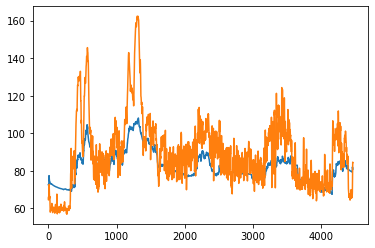

13-TS:(11.011163, 12.340547)
best val epoch: 1
[1/80]: loss_train: 15.083 loss_val 16.243 loss_ts 11.876
best val epoch: 2
[2/80]: loss_train: 13.747 loss_val 14.661 loss_ts 9.930
best val epoch: 4
[4/80]: loss_train: 11.696 loss_val 11.877 loss_ts 11.359
best val epoch: 5
[5/80]: loss_train: 10.026 loss_val 10.364 loss_ts 10.310
best val epoch: 7
[7/80]: loss_train: 9.310 loss_val 9.362 loss_ts 11.815
best val epoch: 11
[11/80]: loss_train: 7.678 loss_val 7.683 loss_ts 9.145
best val epoch: 17
[17/80]: loss_train: 7.202 loss_val 7.405 loss_ts 19.747
best val epoch: 22
[22/80]: loss_train: 6.895 loss_val 7.173 loss_ts 7.726
best val epoch: 46
[46/80]: loss_train: 6.555 loss_val 6.971 loss_ts 8.271
best val epoch: 51
[51/80]: loss_train: 6.024 loss_val 6.684 loss_ts 10.638
Final: 10.638453483581543
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 

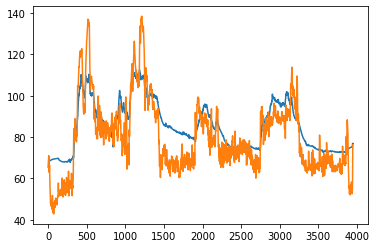

14-TS:(9.019251, 9.9283285)
best val epoch: 1
[1/80]: loss_train: 15.950 loss_val 15.328 loss_ts 16.199
best val epoch: 2
[2/80]: loss_train: 14.719 loss_val 14.222 loss_ts 12.318
best val epoch: 4
[4/80]: loss_train: 12.177 loss_val 11.416 loss_ts 8.297
best val epoch: 5
[5/80]: loss_train: 9.300 loss_val 9.538 loss_ts 11.145
best val epoch: 7
[7/80]: loss_train: 7.936 loss_val 8.125 loss_ts 7.743
best val epoch: 10
[10/80]: loss_train: 6.989 loss_val 7.270 loss_ts 30.839
best val epoch: 20
[20/80]: loss_train: 6.434 loss_val 7.105 loss_ts 11.126
best val epoch: 34
[34/80]: loss_train: 6.280 loss_val 7.074 loss_ts 10.874
best val epoch: 52
[52/80]: loss_train: 5.983 loss_val 6.932 loss_ts 10.915
Final: 10.915487289428711
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 0, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.004500000000000

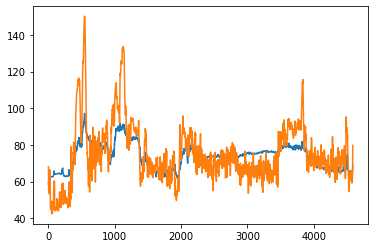

0-TS:(8.619125, 9.638434)
best val epoch: 1
[1/80]: loss_train: 15.187 loss_val 13.996 loss_ts 9.830
best val epoch: 3
[3/80]: loss_train: 12.960 loss_val 12.851 loss_ts 18.763
best val epoch: 4
[4/80]: loss_train: 11.947 loss_val 11.530 loss_ts 29.089
best val epoch: 7
[7/80]: loss_train: 10.365 loss_val 10.156 loss_ts 16.724
best val epoch: 10
[10/80]: loss_train: 8.913 loss_val 9.198 loss_ts 11.107
best val epoch: 11
[11/80]: loss_train: 8.252 loss_val 8.459 loss_ts 6.787
best val epoch: 16
[16/80]: loss_train: 7.876 loss_val 8.293 loss_ts 10.082
best val epoch: 17
[17/80]: loss_train: 7.036 loss_val 7.325 loss_ts 9.163
best val epoch: 31
[31/80]: loss_train: 6.459 loss_val 7.026 loss_ts 8.661
best val epoch: 33
[33/80]: loss_train: 6.179 loss_val 6.648 loss_ts 7.338
best val epoch: 56
[56/80]: loss_train: 5.937 loss_val 6.508 loss_ts 6.380
best val epoch: 62
[62/80]: loss_train: 5.967 loss_val 6.395 loss_ts 7.972
Final: 7.97153902053833
{'net_args': {'dropout_rate': 0.15, 'lstm_inp

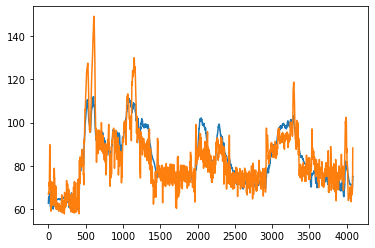

1-TS:(5.3961344, 7.9915333)
best val epoch: 1
[1/80]: loss_train: 15.141 loss_val 16.115 loss_ts 8.858
best val epoch: 2
[2/80]: loss_train: 14.812 loss_val 16.035 loss_ts 10.410
best val epoch: 3
[3/80]: loss_train: 13.955 loss_val 15.422 loss_ts 10.041
best val epoch: 4
[4/80]: loss_train: 13.819 loss_val 14.809 loss_ts 12.643
best val epoch: 5
[5/80]: loss_train: 11.039 loss_val 11.663 loss_ts 19.311
best val epoch: 8
[8/80]: loss_train: 9.795 loss_val 10.460 loss_ts 12.046
best val epoch: 9
[9/80]: loss_train: 7.891 loss_val 8.329 loss_ts 18.503
best val epoch: 17
[17/80]: loss_train: 7.340 loss_val 8.078 loss_ts 9.356
best val epoch: 34
[34/80]: loss_train: 7.108 loss_val 8.011 loss_ts 12.150
best val epoch: 50
[50/80]: loss_train: 6.722 loss_val 7.763 loss_ts 10.646
best val epoch: 53
[53/80]: loss_train: 6.520 loss_val 7.467 loss_ts 11.632
Final: 11.631601333618164
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nat

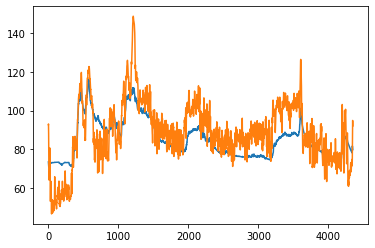

2-TS:(9.258995, 10.31889)
best val epoch: 1
[1/80]: loss_train: 15.963 loss_val 16.174 loss_ts 8.653
best val epoch: 2
[2/80]: loss_train: 14.163 loss_val 14.763 loss_ts 9.456
best val epoch: 3
[3/80]: loss_train: 13.462 loss_val 13.897 loss_ts 9.604
best val epoch: 5
[5/80]: loss_train: 11.446 loss_val 12.076 loss_ts 15.892
best val epoch: 7
[7/80]: loss_train: 11.367 loss_val 11.719 loss_ts 14.091
best val epoch: 8
[8/80]: loss_train: 10.846 loss_val 11.576 loss_ts 17.311
best val epoch: 9
[9/80]: loss_train: 9.124 loss_val 9.592 loss_ts 14.088
best val epoch: 11
[11/80]: loss_train: 8.568 loss_val 8.540 loss_ts 26.833
best val epoch: 16
[16/80]: loss_train: 7.591 loss_val 7.257 loss_ts 12.988
best val epoch: 68
[68/80]: loss_train: 5.448 loss_val 6.289 loss_ts 12.106
Final: 12.105637550354004
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 't

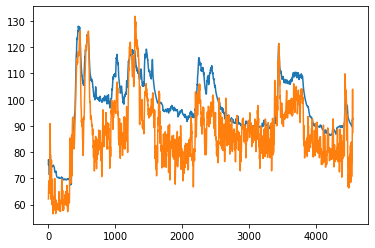

3-TS:(10.650836, 17.463438)
best val epoch: 1
[1/80]: loss_train: 12.679 loss_val 12.828 loss_ts 44.547
best val epoch: 3
[3/80]: loss_train: 11.507 loss_val 11.852 loss_ts 43.932
best val epoch: 7
[7/80]: loss_train: 9.715 loss_val 10.401 loss_ts 47.223
best val epoch: 8
[8/80]: loss_train: 9.578 loss_val 10.298 loss_ts 38.163
best val epoch: 10
[10/80]: loss_train: 9.375 loss_val 10.138 loss_ts 39.449
best val epoch: 11
[11/80]: loss_train: 7.509 loss_val 8.066 loss_ts 48.380
best val epoch: 15
[15/80]: loss_train: 6.431 loss_val 6.841 loss_ts 45.652
best val epoch: 42
[42/80]: loss_train: 5.757 loss_val 6.469 loss_ts 50.993
best val epoch: 75
[75/80]: loss_train: 5.350 loss_val 6.284 loss_ts 34.049
Final: 34.04905319213867
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 4, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.00450000000

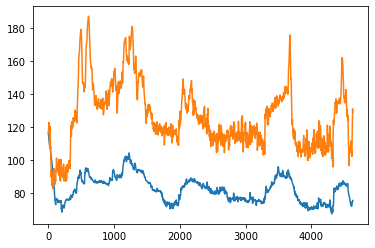

4-TS:(43.430115, 43.495132)
best val epoch: 1
[1/80]: loss_train: 13.872 loss_val 13.632 loss_ts 30.392
best val epoch: 3
[3/80]: loss_train: 12.217 loss_val 12.304 loss_ts 39.396
best val epoch: 4
[4/80]: loss_train: 10.644 loss_val 10.601 loss_ts 21.699
best val epoch: 6
[6/80]: loss_train: 10.527 loss_val 10.480 loss_ts 46.373
best val epoch: 7
[7/80]: loss_train: 8.280 loss_val 8.555 loss_ts 41.281
best val epoch: 10
[10/80]: loss_train: 7.234 loss_val 7.612 loss_ts 42.362
best val epoch: 13
[13/80]: loss_train: 6.996 loss_val 7.596 loss_ts 34.071
best val epoch: 38
[38/80]: loss_train: 6.761 loss_val 7.415 loss_ts 38.029
best val epoch: 40
[40/80]: loss_train: 6.334 loss_val 7.122 loss_ts 37.247
best val epoch: 41
[41/80]: loss_train: 6.115 loss_val 6.953 loss_ts 39.060
best val epoch: 54
[54/80]: loss_train: 6.038 loss_val 6.930 loss_ts 34.663
Final: 34.662757873535156
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, '

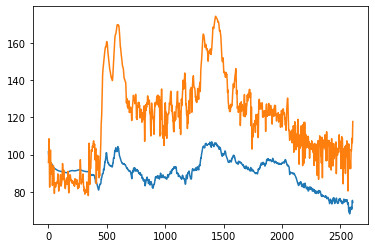

5-TS:(30.742554, 31.110947)
best val epoch: 1
[1/80]: loss_train: 16.252 loss_val 16.639 loss_ts 17.485
best val epoch: 2
[2/80]: loss_train: 13.731 loss_val 13.889 loss_ts 15.853
best val epoch: 3
[3/80]: loss_train: 13.106 loss_val 13.260 loss_ts 12.396
best val epoch: 4
[4/80]: loss_train: 11.226 loss_val 11.115 loss_ts 27.525
best val epoch: 6
[6/80]: loss_train: 10.006 loss_val 10.348 loss_ts 10.479
best val epoch: 8
[8/80]: loss_train: 9.559 loss_val 9.987 loss_ts 10.085
best val epoch: 13
[13/80]: loss_train: 6.668 loss_val 7.178 loss_ts 38.459
best val epoch: 32
[32/80]: loss_train: 6.615 loss_val 7.026 loss_ts 28.514
best val epoch: 36
[36/80]: loss_train: 5.842 loss_val 6.356 loss_ts 33.105
best val epoch: 38
[38/80]: loss_train: 5.646 loss_val 6.322 loss_ts 33.706
best val epoch: 62
[62/80]: loss_train: 5.328 loss_val 6.244 loss_ts 12.764
Final: 12.763570785522461
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, '

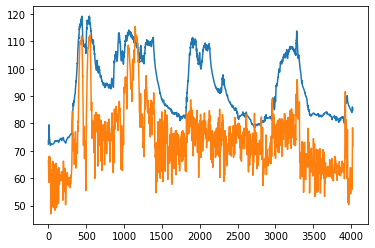

7-TS:(18.808533, 19.85589)
best val epoch: 1
[1/80]: loss_train: 15.686 loss_val 17.300 loss_ts 12.753
best val epoch: 2
[2/80]: loss_train: 14.143 loss_val 15.402 loss_ts 9.799
best val epoch: 5
[5/80]: loss_train: 13.765 loss_val 14.961 loss_ts 10.500
best val epoch: 6
[6/80]: loss_train: 12.806 loss_val 14.026 loss_ts 17.165
best val epoch: 7
[7/80]: loss_train: 10.480 loss_val 11.284 loss_ts 23.937
best val epoch: 11
[11/80]: loss_train: 8.354 loss_val 8.954 loss_ts 12.656
best val epoch: 19
[19/80]: loss_train: 6.757 loss_val 7.351 loss_ts 22.632
best val epoch: 33
[33/80]: loss_train: 6.394 loss_val 6.935 loss_ts 17.926
best val epoch: 41
[41/80]: loss_train: 6.390 loss_val 6.884 loss_ts 10.687
best val epoch: 74
[74/80]: loss_train: 6.023 loss_val 6.635 loss_ts 9.198
Final: 9.197832107543945
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50,

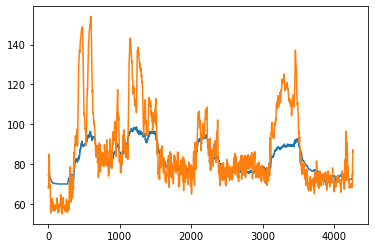

8-TS:(9.645706, 10.838079)
best val epoch: 1
[1/80]: loss_train: 15.239 loss_val 15.586 loss_ts 10.207
best val epoch: 2
[2/80]: loss_train: 14.407 loss_val 15.165 loss_ts 10.711
best val epoch: 4
[4/80]: loss_train: 11.682 loss_val 11.206 loss_ts 14.730
best val epoch: 5
[5/80]: loss_train: 8.534 loss_val 8.715 loss_ts 7.939
best val epoch: 10
[10/80]: loss_train: 7.386 loss_val 7.637 loss_ts 8.323
best val epoch: 15
[15/80]: loss_train: 7.145 loss_val 7.571 loss_ts 10.686
best val epoch: 16
[16/80]: loss_train: 7.482 loss_val 7.511 loss_ts 25.202
best val epoch: 45
[45/80]: loss_train: 6.857 loss_val 7.478 loss_ts 11.036
best val epoch: 54
[54/80]: loss_train: 6.815 loss_val 7.407 loss_ts 10.193
best val epoch: 63
[63/80]: loss_train: 6.206 loss_val 7.125 loss_ts 10.603
best val epoch: 73
[73/80]: loss_train: 6.218 loss_val 7.101 loss_ts 15.237
best val epoch: 75
[75/80]: loss_train: 6.216 loss_val 6.840 loss_ts 12.023
best val epoch: 78
[78/80]: loss_train: 5.682 loss_val 6.730 loss

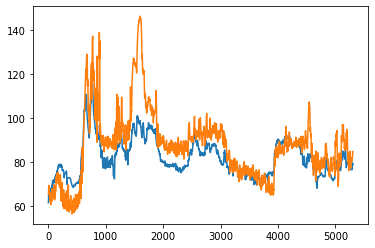

9-TS:(8.241679, 9.661077)
best val epoch: 1
[1/80]: loss_train: 14.976 loss_val 16.602 loss_ts 20.800
best val epoch: 2
[2/80]: loss_train: 14.169 loss_val 16.517 loss_ts 24.927
best val epoch: 3
[3/80]: loss_train: 12.147 loss_val 13.997 loss_ts 20.876
best val epoch: 5
[5/80]: loss_train: 9.754 loss_val 11.042 loss_ts 26.661
best val epoch: 7
[7/80]: loss_train: 8.447 loss_val 9.305 loss_ts 27.952
best val epoch: 11
[11/80]: loss_train: 7.841 loss_val 9.214 loss_ts 28.366
best val epoch: 14
[14/80]: loss_train: 7.019 loss_val 7.956 loss_ts 27.514
best val epoch: 16
[16/80]: loss_train: 6.505 loss_val 7.859 loss_ts 23.081
best val epoch: 18
[18/80]: loss_train: 6.528 loss_val 7.741 loss_ts 27.679
best val epoch: 54
[54/80]: loss_train: 5.921 loss_val 7.615 loss_ts 19.085
best val epoch: 65
[65/80]: loss_train: 5.486 loss_val 6.889 loss_ts 21.173
Final: 21.172727584838867
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nat

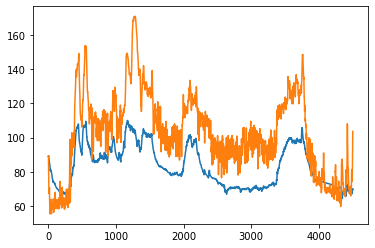

10-TS:(21.384398, 21.749952)
best val epoch: 1
[1/80]: loss_train: 16.710 loss_val 16.403 loss_ts 16.840
best val epoch: 2
[2/80]: loss_train: 15.151 loss_val 14.933 loss_ts 19.627
best val epoch: 3
[3/80]: loss_train: 14.117 loss_val 14.363 loss_ts 22.268
best val epoch: 4
[4/80]: loss_train: 13.459 loss_val 13.858 loss_ts 18.610
best val epoch: 5
[5/80]: loss_train: 12.274 loss_val 12.323 loss_ts 23.154
best val epoch: 9
[9/80]: loss_train: 10.554 loss_val 10.436 loss_ts 14.023
best val epoch: 12
[12/80]: loss_train: 8.813 loss_val 8.531 loss_ts 16.815
best val epoch: 13
[13/80]: loss_train: 8.541 loss_val 8.191 loss_ts 18.986
best val epoch: 15
[15/80]: loss_train: 7.841 loss_val 8.144 loss_ts 14.763
best val epoch: 17
[17/80]: loss_train: 8.470 loss_val 8.143 loss_ts 13.941
best val epoch: 19
[19/80]: loss_train: 8.646 loss_val 8.126 loss_ts 13.321
best val epoch: 20
[20/80]: loss_train: 7.336 loss_val 7.019 loss_ts 17.210
best val epoch: 32
[32/80]: loss_train: 6.688 loss_val 6.74

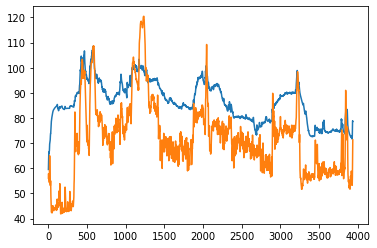

11-TS:(15.923029, 16.213573)
best val epoch: 1
[1/80]: loss_train: 15.194 loss_val 15.788 loss_ts 14.646
best val epoch: 2
[2/80]: loss_train: 14.491 loss_val 15.141 loss_ts 12.308
best val epoch: 3
[3/80]: loss_train: 13.694 loss_val 14.059 loss_ts 12.627
best val epoch: 4
[4/80]: loss_train: 12.887 loss_val 13.262 loss_ts 18.176
best val epoch: 5
[5/80]: loss_train: 10.116 loss_val 10.623 loss_ts 15.069
best val epoch: 6
[6/80]: loss_train: 8.937 loss_val 9.482 loss_ts 25.951
best val epoch: 9
[9/80]: loss_train: 8.281 loss_val 8.615 loss_ts 14.499
best val epoch: 10
[10/80]: loss_train: 7.775 loss_val 7.972 loss_ts 14.531
best val epoch: 23
[23/80]: loss_train: 6.630 loss_val 6.617 loss_ts 12.909
best val epoch: 67
[67/80]: loss_train: 5.670 loss_val 6.307 loss_ts 11.079
Final: 11.078714370727539
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50

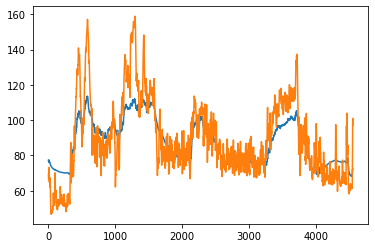

12-TS:(9.744674, 12.343711)
best val epoch: 1
[1/80]: loss_train: 16.166 loss_val 16.017 loss_ts 12.614
best val epoch: 2
[2/80]: loss_train: 13.785 loss_val 14.335 loss_ts 11.435
best val epoch: 5
[5/80]: loss_train: 9.982 loss_val 10.245 loss_ts 15.745
best val epoch: 6
[6/80]: loss_train: 7.422 loss_val 8.147 loss_ts 31.025
best val epoch: 14
[14/80]: loss_train: 7.228 loss_val 7.723 loss_ts 12.710
best val epoch: 21
[21/80]: loss_train: 6.756 loss_val 7.542 loss_ts 11.057
best val epoch: 23
[23/80]: loss_train: 6.567 loss_val 7.430 loss_ts 10.931
best val epoch: 26
[26/80]: loss_train: 6.450 loss_val 7.416 loss_ts 11.795
best val epoch: 30
[30/80]: loss_train: 6.235 loss_val 7.257 loss_ts 11.388
best val epoch: 31
[31/80]: loss_train: 6.285 loss_val 7.232 loss_ts 14.451
best val epoch: 70
[70/80]: loss_train: 5.974 loss_val 7.056 loss_ts 16.187
Final: 16.187135696411133
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'n

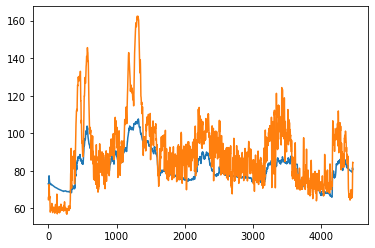

13-TS:(11.513138, 12.890059)
best val epoch: 1
[1/80]: loss_train: 16.105 loss_val 15.814 loss_ts 13.262
best val epoch: 2
[2/80]: loss_train: 15.026 loss_val 14.793 loss_ts 11.167
best val epoch: 3
[3/80]: loss_train: 13.703 loss_val 13.827 loss_ts 10.344
best val epoch: 4
[4/80]: loss_train: 12.141 loss_val 11.937 loss_ts 22.494
best val epoch: 5
[5/80]: loss_train: 11.760 loss_val 11.860 loss_ts 14.148
best val epoch: 6
[6/80]: loss_train: 11.110 loss_val 11.146 loss_ts 30.462
best val epoch: 8
[8/80]: loss_train: 9.548 loss_val 10.192 loss_ts 10.278
best val epoch: 10
[10/80]: loss_train: 9.805 loss_val 10.089 loss_ts 10.853
best val epoch: 13
[13/80]: loss_train: 8.754 loss_val 8.752 loss_ts 14.023
best val epoch: 16
[16/80]: loss_train: 7.758 loss_val 7.963 loss_ts 22.627
best val epoch: 17
[17/80]: loss_train: 7.407 loss_val 7.488 loss_ts 23.186
best val epoch: 19
[19/80]: loss_train: 6.958 loss_val 7.289 loss_ts 19.108
best val epoch: 20
[20/80]: loss_train: 6.713 loss_val 6.87

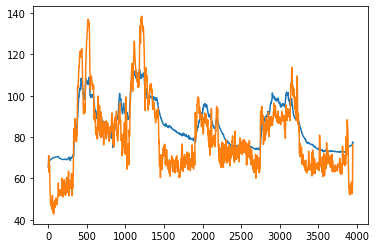

14-TS:(9.187706, 10.007569)
best val epoch: 1
[1/80]: loss_train: 15.688 loss_val 14.573 loss_ts 12.654
best val epoch: 2
[2/80]: loss_train: 14.758 loss_val 13.652 loss_ts 13.448
best val epoch: 3
[3/80]: loss_train: 14.180 loss_val 13.301 loss_ts 12.570
best val epoch: 5
[5/80]: loss_train: 12.107 loss_val 11.781 loss_ts 11.703
best val epoch: 6
[6/80]: loss_train: 11.365 loss_val 10.933 loss_ts 28.927
best val epoch: 7
[7/80]: loss_train: 9.716 loss_val 9.772 loss_ts 8.285
best val epoch: 9
[9/80]: loss_train: 8.060 loss_val 7.852 loss_ts 27.358
best val epoch: 21
[21/80]: loss_train: 7.393 loss_val 7.677 loss_ts 11.817
best val epoch: 35
[35/80]: loss_train: 6.763 loss_val 7.216 loss_ts 14.491
best val epoch: 39
[39/80]: loss_train: 5.880 loss_val 6.468 loss_ts 8.556
best val epoch: 67
[67/80]: loss_train: 5.884 loss_val 6.446 loss_ts 16.886
Final: 16.885719299316406
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'natt

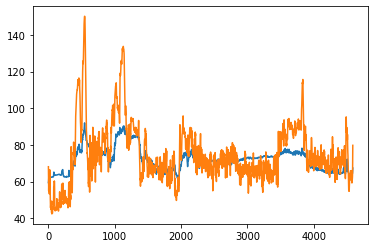

0-TS:(8.940387, 10.673759)
best val epoch: 1
[1/80]: loss_train: 17.206 loss_val 16.443 loss_ts 7.369
best val epoch: 2
[2/80]: loss_train: 15.738 loss_val 15.672 loss_ts 11.109
best val epoch: 3
[3/80]: loss_train: 14.521 loss_val 14.497 loss_ts 9.820
best val epoch: 4
[4/80]: loss_train: 13.018 loss_val 13.276 loss_ts 10.117
best val epoch: 6
[6/80]: loss_train: 11.862 loss_val 11.706 loss_ts 6.766
best val epoch: 9
[9/80]: loss_train: 9.680 loss_val 10.126 loss_ts 7.518
best val epoch: 10
[10/80]: loss_train: 9.564 loss_val 9.732 loss_ts 8.208
best val epoch: 11
[11/80]: loss_train: 9.311 loss_val 9.624 loss_ts 23.947
best val epoch: 13
[13/80]: loss_train: 7.638 loss_val 8.481 loss_ts 29.408
best val epoch: 19
[19/80]: loss_train: 6.393 loss_val 7.613 loss_ts 20.965
best val epoch: 43
[43/80]: loss_train: 6.314 loss_val 7.541 loss_ts 6.731
best val epoch: 48
[48/80]: loss_train: 6.236 loss_val 7.360 loss_ts 7.593
best val epoch: 51
[51/80]: loss_train: 5.800 loss_val 6.774 loss_ts 

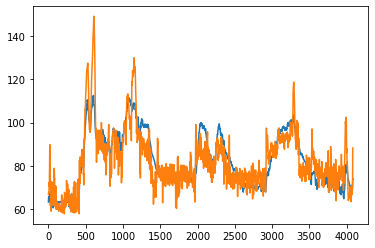

1-TS:(5.6297765, 8.2145)
best val epoch: 1
[1/80]: loss_train: 16.134 loss_val 17.402 loss_ts 10.815
best val epoch: 2
[2/80]: loss_train: 14.915 loss_val 16.408 loss_ts 9.049
best val epoch: 3
[3/80]: loss_train: 13.889 loss_val 15.689 loss_ts 9.613
best val epoch: 4
[4/80]: loss_train: 13.267 loss_val 14.999 loss_ts 11.780
best val epoch: 5
[5/80]: loss_train: 10.460 loss_val 11.864 loss_ts 15.449
best val epoch: 7
[7/80]: loss_train: 9.568 loss_val 10.751 loss_ts 11.488
best val epoch: 9
[9/80]: loss_train: 7.144 loss_val 7.742 loss_ts 10.992
best val epoch: 35
[35/80]: loss_train: 6.080 loss_val 7.165 loss_ts 8.789
best val epoch: 72
[72/80]: loss_train: 5.822 loss_val 7.154 loss_ts 8.765
Final: 8.764811515808105
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 2, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005}

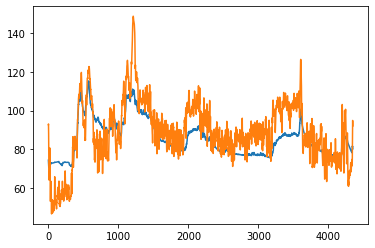

2-TS:(9.118691, 10.096879)
best val epoch: 1
[1/80]: loss_train: 16.330 loss_val 16.210 loss_ts 9.462
best val epoch: 2
[2/80]: loss_train: 14.600 loss_val 14.066 loss_ts 9.283
best val epoch: 3
[3/80]: loss_train: 13.829 loss_val 13.598 loss_ts 9.217
best val epoch: 4
[4/80]: loss_train: 11.533 loss_val 11.287 loss_ts 15.503
best val epoch: 6
[6/80]: loss_train: 10.487 loss_val 9.862 loss_ts 20.357
best val epoch: 7
[7/80]: loss_train: 8.606 loss_val 8.506 loss_ts 11.336
best val epoch: 8
[8/80]: loss_train: 7.979 loss_val 7.640 loss_ts 24.179
best val epoch: 23
[23/80]: loss_train: 7.244 loss_val 7.579 loss_ts 18.865
best val epoch: 24
[24/80]: loss_train: 6.781 loss_val 7.023 loss_ts 25.634
best val epoch: 32
[32/80]: loss_train: 6.591 loss_val 7.006 loss_ts 16.562
best val epoch: 39
[39/80]: loss_train: 6.378 loss_val 6.921 loss_ts 23.848
best val epoch: 40
[40/80]: loss_train: 6.037 loss_val 6.477 loss_ts 14.737
Final: 14.737175941467285
{'net_args': {'dropout_rate': 0.15, 'lstm_i

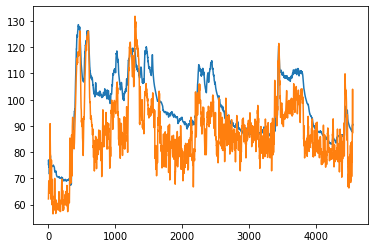

3-TS:(10.473122, 17.073973)
best val epoch: 1
[1/80]: loss_train: 14.111 loss_val 15.703 loss_ts 46.780
best val epoch: 2
[2/80]: loss_train: 11.991 loss_val 13.281 loss_ts 46.788
best val epoch: 3
[3/80]: loss_train: 10.428 loss_val 11.808 loss_ts 52.506
best val epoch: 6
[6/80]: loss_train: 10.256 loss_val 11.614 loss_ts 53.470
best val epoch: 8
[8/80]: loss_train: 9.532 loss_val 10.741 loss_ts 55.663
best val epoch: 10
[10/80]: loss_train: 8.488 loss_val 9.603 loss_ts 53.446
best val epoch: 19
[19/80]: loss_train: 7.239 loss_val 8.494 loss_ts 51.985
best val epoch: 32
[32/80]: loss_train: 6.481 loss_val 7.919 loss_ts 51.916
best val epoch: 35
[35/80]: loss_train: 6.313 loss_val 7.635 loss_ts 53.875
best val epoch: 46
[46/80]: loss_train: 6.074 loss_val 7.383 loss_ts 44.154
Final: 44.15397644042969
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 5

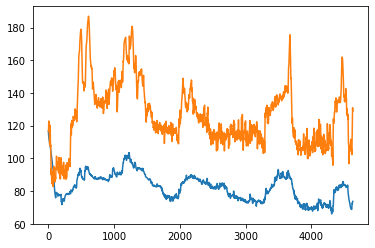

4-TS:(43.511032, 43.589252)
best val epoch: 1
[1/80]: loss_train: 15.875 loss_val 16.169 loss_ts 39.949
best val epoch: 2
[2/80]: loss_train: 12.600 loss_val 13.203 loss_ts 30.486
best val epoch: 3
[3/80]: loss_train: 11.165 loss_val 11.674 loss_ts 31.775
best val epoch: 4
[4/80]: loss_train: 10.305 loss_val 10.298 loss_ts 36.590
best val epoch: 6
[6/80]: loss_train: 9.966 loss_val 9.710 loss_ts 42.890
best val epoch: 9
[9/80]: loss_train: 8.316 loss_val 8.241 loss_ts 32.799
best val epoch: 10
[10/80]: loss_train: 8.094 loss_val 7.960 loss_ts 40.100
best val epoch: 15
[15/80]: loss_train: 7.867 loss_val 7.824 loss_ts 35.716
best val epoch: 17
[17/80]: loss_train: 7.080 loss_val 7.024 loss_ts 34.218
best val epoch: 28
[28/80]: loss_train: 7.195 loss_val 6.970 loss_ts 36.656
best val epoch: 40
[40/80]: loss_train: 6.641 loss_val 6.711 loss_ts 34.937
best val epoch: 48
[48/80]: loss_train: 6.716 loss_val 6.625 loss_ts 34.794
best val epoch: 50
[50/80]: loss_train: 6.470 loss_val 6.506 los

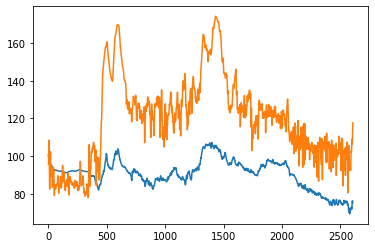

5-TS:(30.698912, 31.022892)
best val epoch: 1
[1/80]: loss_train: 17.311 loss_val 18.936 loss_ts 13.207
best val epoch: 2
[2/80]: loss_train: 16.432 loss_val 18.056 loss_ts 12.379
best val epoch: 3
[3/80]: loss_train: 14.660 loss_val 15.718 loss_ts 11.257
best val epoch: 4
[4/80]: loss_train: 13.418 loss_val 14.944 loss_ts 10.385
best val epoch: 5
[5/80]: loss_train: 11.432 loss_val 11.972 loss_ts 16.235
best val epoch: 7
[7/80]: loss_train: 9.438 loss_val 10.204 loss_ts 14.195
best val epoch: 8
[8/80]: loss_train: 7.490 loss_val 8.621 loss_ts 25.712
best val epoch: 21
[21/80]: loss_train: 6.193 loss_val 7.208 loss_ts 14.401
best val epoch: 63
[63/80]: loss_train: 5.709 loss_val 7.046 loss_ts 10.821
Final: 10.821429252624512
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 6, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.004500000000

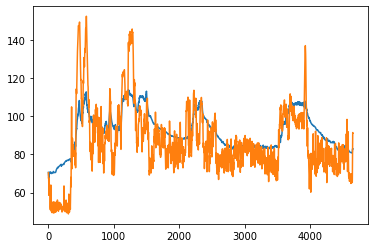

6-TS:(10.801215, 15.0945015)
best val epoch: 1
[1/80]: loss_train: 15.632 loss_val 16.406 loss_ts 12.055
best val epoch: 2
[2/80]: loss_train: 14.465 loss_val 15.638 loss_ts 9.153
best val epoch: 3
[3/80]: loss_train: 14.540 loss_val 15.541 loss_ts 12.253
best val epoch: 5
[5/80]: loss_train: 12.424 loss_val 13.023 loss_ts 15.359
best val epoch: 6
[6/80]: loss_train: 10.464 loss_val 10.948 loss_ts 16.244
best val epoch: 8
[8/80]: loss_train: 9.971 loss_val 10.431 loss_ts 14.021
best val epoch: 10
[10/80]: loss_train: 7.780 loss_val 8.351 loss_ts 13.893
best val epoch: 17
[17/80]: loss_train: 7.520 loss_val 7.900 loss_ts 14.392
best val epoch: 23
[23/80]: loss_train: 6.918 loss_val 7.519 loss_ts 14.305
best val epoch: 27
[27/80]: loss_train: 6.498 loss_val 7.023 loss_ts 13.202
best val epoch: 29
[29/80]: loss_train: 6.223 loss_val 6.672 loss_ts 12.937
best val epoch: 67
[67/80]: loss_train: 5.876 loss_val 6.620 loss_ts 13.746
Final: 13.745892524719238
{'net_args': {'dropout_rate': 0.15,

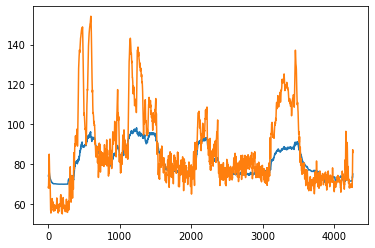

8-TS:(9.881012, 11.201555)
best val epoch: 1
[1/80]: loss_train: 17.235 loss_val 16.862 loss_ts 11.790
best val epoch: 2
[2/80]: loss_train: 15.260 loss_val 14.608 loss_ts 9.445
best val epoch: 3
[3/80]: loss_train: 14.831 loss_val 14.493 loss_ts 10.245
best val epoch: 4
[4/80]: loss_train: 13.182 loss_val 12.576 loss_ts 7.801
best val epoch: 5
[5/80]: loss_train: 11.434 loss_val 11.521 loss_ts 15.226
best val epoch: 6
[6/80]: loss_train: 11.226 loss_val 10.982 loss_ts 12.797
best val epoch: 8
[8/80]: loss_train: 9.960 loss_val 9.863 loss_ts 14.914
best val epoch: 12
[12/80]: loss_train: 9.136 loss_val 9.183 loss_ts 10.945
best val epoch: 15
[15/80]: loss_train: 9.385 loss_val 8.820 loss_ts 15.566
best val epoch: 18
[18/80]: loss_train: 7.107 loss_val 6.923 loss_ts 8.544
best val epoch: 23
[23/80]: loss_train: 6.711 loss_val 6.786 loss_ts 9.624
best val epoch: 29
[29/80]: loss_train: 6.845 loss_val 6.668 loss_ts 6.905
best val epoch: 40
[40/80]: loss_train: 6.507 loss_val 6.404 loss_ts

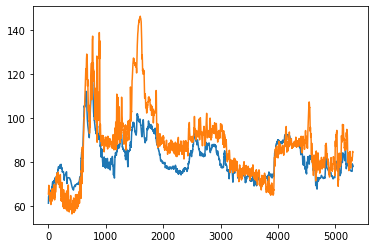

9-TS:(8.4077015, 9.755996)
best val epoch: 1
[1/80]: loss_train: 13.933 loss_val 15.179 loss_ts 20.575
best val epoch: 3
[3/80]: loss_train: 12.520 loss_val 13.850 loss_ts 22.762
best val epoch: 6
[6/80]: loss_train: 10.395 loss_val 10.105 loss_ts 21.882
best val epoch: 10
[10/80]: loss_train: 7.489 loss_val 8.120 loss_ts 22.018
best val epoch: 43
[43/80]: loss_train: 7.006 loss_val 7.728 loss_ts 15.885
best val epoch: 45
[45/80]: loss_train: 6.488 loss_val 7.314 loss_ts 14.235
best val epoch: 70
[70/80]: loss_train: 5.785 loss_val 7.015 loss_ts 11.738
Final: 11.737685203552246
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 10, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 11.737685


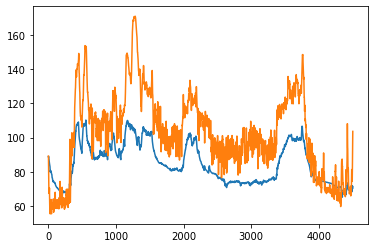

10-TS:(19.808311, 20.498419)
best val epoch: 1
[1/80]: loss_train: 15.570 loss_val 15.367 loss_ts 15.289
best val epoch: 2
[2/80]: loss_train: 14.644 loss_val 14.610 loss_ts 16.163
best val epoch: 3
[3/80]: loss_train: 13.248 loss_val 13.283 loss_ts 21.546
best val epoch: 5
[5/80]: loss_train: 12.243 loss_val 12.113 loss_ts 11.595
best val epoch: 7
[7/80]: loss_train: 8.750 loss_val 8.928 loss_ts 46.349
best val epoch: 8
[8/80]: loss_train: 8.637 loss_val 8.362 loss_ts 14.118
best val epoch: 10
[10/80]: loss_train: 8.062 loss_val 8.034 loss_ts 12.608
best val epoch: 11
[11/80]: loss_train: 8.003 loss_val 7.835 loss_ts 15.572
best val epoch: 12
[12/80]: loss_train: 7.467 loss_val 7.710 loss_ts 35.882
best val epoch: 17
[17/80]: loss_train: 7.175 loss_val 7.211 loss_ts 32.966
best val epoch: 18
[18/80]: loss_train: 7.134 loss_val 7.060 loss_ts 11.414
best val epoch: 36
[36/80]: loss_train: 6.552 loss_val 6.914 loss_ts 13.637
best val epoch: 40
[40/80]: loss_train: 6.287 loss_val 6.536 lo

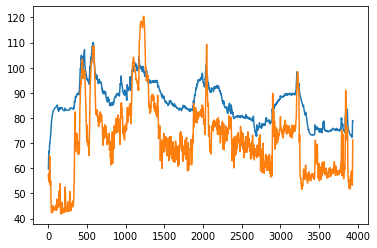

11-TS:(15.621664, 15.8952265)
best val epoch: 1
[1/80]: loss_train: 16.236 loss_val 15.560 loss_ts 15.152
best val epoch: 2
[2/80]: loss_train: 14.644 loss_val 14.088 loss_ts 14.082
best val epoch: 4
[4/80]: loss_train: 13.344 loss_val 13.527 loss_ts 24.184
best val epoch: 5
[5/80]: loss_train: 10.410 loss_val 10.287 loss_ts 22.826
best val epoch: 6
[6/80]: loss_train: 7.552 loss_val 7.186 loss_ts 20.551
best val epoch: 17
[17/80]: loss_train: 6.611 loss_val 6.448 loss_ts 31.733
best val epoch: 69
[69/80]: loss_train: 5.907 loss_val 6.368 loss_ts 10.396
best val epoch: 77
[77/80]: loss_train: 4.788 loss_val 5.652 loss_ts 9.619
Final: 9.619461059570312
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 12, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 9.619461


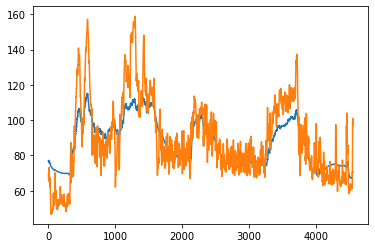

12-TS:(9.542934, 12.00318)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 13, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 16.019587


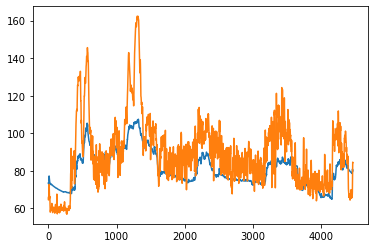

13-TS:(11.780752, 13.281251)
{'net_args': {'dropout_rate': 0.15, 'lstm_input': 128, 'lstm_size': 64, 'ts_h_size': 16, 'sample_per_ts': 128, 'nattrs': 7}, 'period_s': 4, 'step_s': 2, 'ts_per_is': 12, 'ts_per_sample': 50, 'ts_sub': 14, 'batch_size': 64, 'weight_decay': 1e-05, 'lr': 0.0045000000000000005} 9.154209


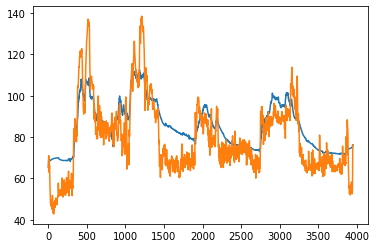

14-TS:(9.100078, 9.900899)


In [ ]:

fchoice = {
    # 'is_h_size': 64,
    'ts_per_is': 12,
    'period_s': 4,
    'step_s': 2,
    'ts_per_sample': 50,
    'ts_sub': 5,
    'batch_size': 64,
    'weight_decay': 1e-05,
    'lr': 0.005*0.9,
    #'nattrs': 40,
    'dropout_rate':0.15,
    'lstm_input': 128,
    'lstm_size': 64,
    'ts_h_size': 16,
    'sample_per_ts': 32*4
    #'disc_nlayers': 5,
    #'disc_layer_size': 64,
    #'disc_dropout_rate': 0.15
}


from PPG import UtilitiesDataXY
from collections import defaultdict
nepoch = 80
aresults = defaultdict(dict)
for val_sub in [4,5,3,2,1,0,6,7]:
  for ts_sub in range(15):
    if val_sub == ts_sub:
      continue
    fchoice["ts_sub"] = ts_sub
    # fchoice["val_sub"] = val_sub
    filename = f"dalia_ts_no_pce_{ts_sub}_val_{val_sub}_nepoch_{nepoch}.pkl"
    save_path = os.path.join(STORE_DIR, filename)
    try:
      with open(save_path , "rb") as f:
        out = pickle.load(f)
    except FileNotFoundError:
      full_trainer = RegressionHR.FullTrainer.NoPceLstmDaliaFullTrainerJointValidation(dfs_train, args["device"], nepoch)
      try:
        out = full_trainer.train(**fchoice)
        with open(save_path, "wb") as f:
          pickle.dump(out, f)

      except RuntimeError as e:
        raise e
        # if isinstance(e, KeyboardInterrupt):
        #   raise e
        # else:
        #   print("####")
        #   print(f"Failed: {choice}")
        #   print("###")
    
    print(out["args"], out["metric"])
    aresults[ts_sub][val_sub] = out
    print(f"{ts_sub}-TS:{compute_ensemble(list(aresults[ts_sub].values()))}")
    

